**Road Collision Analysis and Prediction - MOTOR VEHICLE COLLISIONS INVOLVING KILLED OR SERIOUSLY INJURED PERSONS**

**DATASET**

https://open.toronto.ca/dataset/motor-vehicle-collisions-involving-killed-or-seriously-injured-persons/

This dataset includes all traffic collisions events where a person was either Killed or Seriously Injured (KSI) from 2006 – 2020.

*Limitations*:
This dataset includes all traffic collisions events where a person was either Killed or Seriously Injured (KSI) from 2006 – 2020. The location of crime occurrences have been deliberately offset to the nearest road intersection node to protect the privacy of parties involved in the occurrence. Due to the offset of occurrence location, the numbers by Division and Neighbourhood may not reflect the exact count of occurrences reported within these geographies. Therefore, the Toronto Police Service does not guarantee the accuracy, completeness, timeliness of the data and it should not be compared to any other source of crime data.

**ATTRIBUTE INFORMATION**

_id: Unique row identifier for Open Data database

ACCNUM: Accident Number

YEAR: Year Collision Occurred

DATE: Date Collision Occurred

TIME: Time Collision Occurred

HOUR: Hour Collision Occurred

STREET1: Street Collision Occurred

STREET2: Street Collision Occurred

OFFSET: Distance and direction of the Collision

ROAD_CLASS: Road Classification

DISTRICT: City District

WARDNUM: City Ward Identifier, will show multiple if collision occurred along a border

DIVISION: Police Division(s), will show multiple if collision occurred along a border

LOCCOORD: Location Coordinate

ACCLOC: Collision Location

TRAFFCTL: Traffic Control Type

VISIBILITY: Environment Condition

LIGHT: Light Condition

RDSFCOND: Road Surface Condition

ACCLASS: Classification of Accident

IMPACTYPE: Initial Impact Type

INVTYPE: Involvement Type

INVAGE: Age of Involved Party

INJURY: Severity of Injury

FATAL_NO: Sequential Number

INITDIR: Initial Direction of Travel

VEHTYPE: Type of Vehicle

MANOEUVER: Vehicle Manouever

DRIVACT: Apparent Driver Action

DRIVCOND: Driver Condition

PEDTYPE: Pedestrian Crash Type - detail

PEDACT: Pedestrian Action

PEDCOND: Condition of Pedestrian

CYCLISTYPE: Cyclist Crash Type - detail

CYCACT: Cyclist Action

CYCCOND: Cyclist Condition

PEDESTRIAN: Pedestrian Involved In Collision

CYCLIST: Cyclists Involved in Collision

AUTOMOBILE: Driver Involved in Collision

MOTORCYCLE: Motorcyclist Involved in Collision

TRUCK: Truck Driver Involved in Collision

TRSN_CITY_VEH: Transit or City Vehicle Involved in Collision

EMERG_VEH: Emergency Vehicle Involved in Collision

PASSENGER: Passenger Involved in Collision

SPEEDING: Speeding Related Collision

AG_DRIV: Aggressive and Distracted Driving Collision

REDLIGHT: Red Light Related Collision

ALCOHOL: Alcohol Related Collision

DISABILITY: Medical or Physical Disability Related Collision

POLICE_DIVISION: Toronto Police Service Division

HOOD_ID: City of Toronto Neighbourhood Identifier

NEIGHBOURHOOD: City of Toronto Neighbourhood Name

ObjectId: Object ID (Unique Identifier)

**OBJECTIVE**

The goal of this project is to predict the liklihood of motor vehicle collisions involving killed or seriously injured persons.

We will begin this analysis by inspecting the data, and then performing exploratory analysis. We will then pre-process the data to make it useable for modelling. The modelling design stage involves designining optimal models using hyper-parameter tuning and then discussing the performance.

**LOAD DATA**

In [1]:
#required imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.ensemble  import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble  import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from time import time

from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor

# to make this notebook's output stable across runs
np.random.seed(123)

def check_data_balance(series, style="seaborn-pastel"):
    with plt.style.context(style):
        unique = series.value_counts()
        display(unique) #show unique value counts of the target
        plt.pie(unique, explode=[0.05]*len(unique), labels=unique.index, autopct='%1.1f%%'); #plot a pie chart for the target to see if data are balanced


In [2]:
data = pd.read_csv('Motor Vehicle Collisions with KSI Data - 4326.csv', index_col=0)
data.head()

C:\Users\novikova\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (42) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,ACCNUM,YEAR,DATE,TIME,HOUR,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,...,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,POLICE_DIVISION,HOOD_ID,NEIGHBOURHOOD,ObjectId,geometry
_id,,,,,,,,,,,,,,,,,,,,,
1,892658,2006,2006-03-11T00:00:00,852,8,BLOOR ST W,DUNDAS ST W,NaN,Major Arterial,Toronto and East York,...,NaN,Yes,NaN,NaN,NaN,D11,88,High Park North (88),1,"{'type': 'Point', 'coordinates': (-79.45249, 4..."
2,892658,2006,2006-03-11T00:00:00,852,8,BLOOR ST W,DUNDAS ST W,NaN,Major Arterial,Toronto and East York,...,NaN,Yes,NaN,NaN,NaN,D11,88,High Park North (88),2,"{'type': 'Point', 'coordinates': (-79.45249, 4..."
3,892810,2006,2006-03-11T00:00:00,915,9,MORNINGSIDE AVE,SHEPPARD AVE E,NaN,Major Arterial,Scarborough,...,NaN,Yes,Yes,NaN,NaN,D42,131,Rouge (131),3,"{'type': 'Point', 'coordinates': (-79.199786, ..."
4,892810,2006,2006-03-11T00:00:00,915,9,MORNINGSIDE AVE,SHEPPARD AVE E,NaN,Major Arterial,Scarborough,...,NaN,Yes,Yes,NaN,NaN,D42,131,Rouge (131),4,"{'type': 'Point', 'coordinates': (-79.199786, ..."
5,892682,2006,2006-03-12T00:00:00,240,2,EGLINTON AVE E,COMMONWEALTH AVE,NaN,Major Arterial,Scarborough,...,NaN,NaN,NaN,Yes,NaN,D41,138,Eglinton East (138),5,"{'type': 'Point', 'coordinates': (-79.25619, 4..."


**DATA EXPLORATION**

In [4]:
data.shape

(16860, 53)

There are 16,850 rows and 53 columns.

In [5]:
data.dtypes

ACCNUM               int64
YEAR                 int64
DATE                object
TIME                 int64
HOUR                 int64
STREET1             object
STREET2             object
OFFSET              object
ROAD_CLASS          object
DISTRICT            object
WARDNUM             object
DIVISION            object
LOCCOORD            object
ACCLOC              object
TRAFFCTL            object
VISIBILITY          object
LIGHT               object
RDSFCOND            object
ACCLASS             object
IMPACTYPE           object
INVTYPE             object
INVAGE              object
INJURY              object
FATAL_NO           float64
INITDIR             object
VEHTYPE             object
MANOEUVER           object
DRIVACT             object
DRIVCOND            object
PEDTYPE             object
PEDACT              object
PEDCOND             object
CYCLISTYPE          object
CYCACT              object
CYCCOND             object
PEDESTRIAN          object
CYCLIST             object
A

data.dtype() returns a Series with the data type of each column. The result’s index is the original DataFrame’s columns. It appears that most of the features in this dataset are objects and a few are integers.

In [6]:
data.isnull().sum()

ACCNUM                 0
YEAR                   0
DATE                   0
TIME                   0
HOUR                   0
STREET1                0
STREET2             1510
OFFSET             14114
ROAD_CLASS           497
DISTRICT             141
WARDNUM              196
DIVISION             196
LOCCOORD             105
ACCLOC              5450
TRAFFCTL              29
VISIBILITY            18
LIGHT                  0
RDSFCOND              23
ACCLASS                0
IMPACTYPE              4
INVTYPE               12
INVAGE                 0
INJURY              1612
FATAL_NO           16147
INITDIR             4894
VEHTYPE             2813
MANOEUVER           7233
DRIVACT             8398
DRIVCOND            8396
PEDTYPE            14074
PEDACT             14081
PEDCOND            14025
CYCLISTYPE         16160
CYCACT             16153
CYCCOND            16154
PEDESTRIAN         10033
CYCLIST            15081
AUTOMOBILE          1552
MOTORCYCLE         15476
TRUCK              15818


.isnull.sum() confirms the number of missing values. The Emergency vehicles, alcohol usage, disabilities, pedestrians, and cyclist columns appear to be missing the most data.

**PRE-PROCESSING THE DATA**

*Filling Missing Values*

In [7]:
data.CYCLIST.unique()

array([nan, 'Yes'], dtype=object)

In [8]:
data.STREET2.fillna('Unknown', inplace = True)
data.OFFSET.fillna('None', inplace = True)
data.ROAD_CLASS.fillna('Other', inplace = True)
data.DISTRICT.fillna('Rest of GTA', inplace = True)
data.WARDNUM.fillna('Unknown', inplace = True)
data.DIVISION.fillna('Unknown', inplace = True)
data.LOCCOORD.fillna('Unknown', inplace = True)
data.ACCLOC.fillna('Unknown', inplace = True)
data.TRAFFCTL.fillna('Unknown', inplace = True)
data.VISIBILITY.fillna('Other', inplace = True)
data.RDSFCOND.fillna('Other', inplace = True)
data.IMPACTYPE.fillna('Other', inplace = True)
data.INVAGE.fillna('unknown', inplace = True)
data.INVTYPE.fillna('Other', inplace = True)
data.INITDIR.fillna('Unknown', inplace = True)
data.INJURY.fillna('Unknown', inplace = True)
data.FATAL_NO.fillna('None', inplace = True)
data.VEHTYPE.fillna('Other', inplace = True)
data.MANOEUVER.fillna('Unknown', inplace = True)
data.DRIVACT.fillna('Other', inplace = True)
data.DRIVCOND.fillna('Unknown', inplace = True)
data.PEDTYPE.fillna('Unknown', inplace = True)
data.PEDACT.fillna('Other', inplace = True)
data.PEDCOND.fillna('Other', inplace = True)
data.CYCLISTYPE.fillna('Other', inplace = True)
data.CYCACT.fillna('Other', inplace = True)
data.CYCCOND.fillna('Other', inplace = True)
data.PEDESTRIAN.fillna('No', inplace = True)
data.CYCLIST.fillna('No', inplace = True)
data.AUTOMOBILE.fillna('No', inplace = True)
data.MOTORCYCLE.fillna('No', inplace = True)
data.TRUCK.fillna('No', inplace = True)
data.TRSN_CITY_VEH.fillna('No', inplace = True)
data.EMERG_VEH.fillna('No', inplace = True)
data.PASSENGER.fillna('No', inplace = True)
data.SPEEDING.fillna('No', inplace = True)
data.AG_DRIV.fillna('No', inplace = True)
data.REDLIGHT.fillna('No', inplace = True)
data.ALCOHOL.fillna('No', inplace = True)
data.DISABILITY.fillna('No', inplace = True)

We used .fillna() to replace the null columns with "no", "Other", "Unknown", etc. The values we choose were based on their respective column. For example, if a column was a "yes/no" column, the blanks would become "no", because there was only "yes" and "null" available original. Similarly, if there was already an "unknown" column it would already grouped with those. We used .unique() to gauge what the distinct values are. 

In [9]:
data.isnull().sum()

ACCNUM             0
YEAR               0
DATE               0
TIME               0
HOUR               0
STREET1            0
STREET2            0
OFFSET             0
ROAD_CLASS         0
DISTRICT           0
WARDNUM            0
DIVISION           0
LOCCOORD           0
ACCLOC             0
TRAFFCTL           0
VISIBILITY         0
LIGHT              0
RDSFCOND           0
ACCLASS            0
IMPACTYPE          0
INVTYPE            0
INVAGE             0
INJURY             0
FATAL_NO           0
INITDIR            0
VEHTYPE            0
MANOEUVER          0
DRIVACT            0
DRIVCOND           0
PEDTYPE            0
PEDACT             0
PEDCOND            0
CYCLISTYPE         0
CYCACT             0
CYCCOND            0
PEDESTRIAN         0
CYCLIST            0
AUTOMOBILE         0
MOTORCYCLE         0
TRUCK              0
TRSN_CITY_VEH      0
EMERG_VEH          0
PASSENGER          0
SPEEDING           0
AG_DRIV            0
REDLIGHT           0
ALCOHOL            0
DISABILITY   

All the null values have been removed.

In [ ]:
#Alt Way to deal with missing values

from sklearn.impute import SimpleImputer

#For features with Unknown capital "U"

print(data[['STREET2','WARDNUM', 'DIVISION','LOCCOORD','ACCLOC','TRAFFCTL',
            'INITDIR','INJURY','MANOEUVER','DRIVCOND','PEDTYPE']].values[:, 0])
tfmr = SimpleImputer(strategy='constant', fill_value='Unknown')
# we place double brackets as a trick - sklearn expects arrays of the shape (n, 1). 
# the pandas Series.values method gives the shape (n, ), so we pass a DataFrame instead
# by including a list of one column header.
print(tfmr.fit_transform(data[['STREET2','WARDNUM', 'DIVISION','LOCCOORD','ACCLOC','TRAFFCTL',
            'INITDIR','INJURY','MANOEUVER','DRIVCOND','PEDTYPE']].values)[:, 0])

#For features with unknown lowercase "u", this is to ensure that it gets grouped with the other "unknowns"

print(data[['INVAGE']].values[:, 0])
tfmr = SimpleImputer(strategy='constant', fill_value='unknown')
print(tfmr.fit_transform(data[['INVAGE']].values)[:, 0])

#For features with "none"

print(data[['DISTRICT']].values[:, 0])
tfmr = SimpleImputer(strategy='constant', fill_value='Rest of GTA')
print(tfmr.fit_transform(data[['DISTRICT']].values)[:, 0])

print(data[['OFFSET','FATAL_NO']].values[:, 0])
tfmr = SimpleImputer(strategy='constant', fill_value='None')
print(tfmr.fit_transform(data[['DISTRICT']].values)[:, 0])

#For features with "Other"

print(data[['ROAD_CLASS','VISIBILITY', 'RDSFCOND','IMPACTYPE','INVTYPE','VEHTYPE',
           'DRIVACT','PEDACT', 'PEDCOND', 'CYCLISTYPE', 'CYCACT', 'CYCCOND']].values[:, 0])
tfmr = SimpleImputer(strategy='constant', fill_value='Other')
print(tfmr.fit_transform(data[['ROAD_CLASS','VISIBILITY', 'RDSFCOND','IMPACTYPE','INVTYPE','VEHTYPE',
           'DRIVACT','PEDACT', 'PEDCOND', 'CYCLISTYPE', 'CYCACT', 'CYCCOND']].values)[:, 0])

# For binary variables

print(data[['PEDESTRIAN','CYCLIST', 'AUTOMOBILE','MOTORCYCLE','TRUCK','TRSN_CITY_VEH','EMERG_VEH',
            'PASSENGER','SPEEDING','AG_DRIV','REDLIGHT','ALCOHOL','DISABILITY']].values[:, 0])
tfmr = SimpleImputer(strategy='constant', fill_value='No')
print(tfmr.fit_transform(data[['PEDESTRIAN','CYCLIST', 'AUTOMOBILE','MOTORCYCLE','TRUCK','TRSN_CITY_VEH','EMERG_VEH',
            'PASSENGER','SPEEDING','AG_DRIV','REDLIGHT','ALCOHOL','DISABILITY']].values)[:, 0])

You could also use simple imputer to achieve the same end, just would need to adjust the pipeline. 

**THE TARGET VARIABLE**

In [10]:
data.groupby('INJURY')['ObjectId'].count()
# will need to replace nulls

INJURY
Fatal       821
Major      5668
Minimal    1042
Minor      1311
None       6406
Unknown    1612
Name: ObjectId, dtype: int64

It looks like no injuries and major injuries are the most common types of injuries. Fatalities are relatively uncommon in this dataset.

*Target Variable*

In [11]:
data['TARGET'] = data['INJURY'].replace(['Fatal', 'Major','Minor','Minimal','None', 'Unknown'],[1,1,0,0,0,0])
data.head()

,ACCNUM,YEAR,DATE,TIME,HOUR,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,...,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,POLICE_DIVISION,HOOD_ID,NEIGHBOURHOOD,ObjectId,geometry,TARGET
_id,,,,,,,,,,,,,,,,,,,,,
1,892658,2006,2006-03-11T00:00:00,852,8,BLOOR ST W,DUNDAS ST W,None,Major Arterial,Toronto and East York,...,Yes,No,No,No,D11,88,High Park North (88),1,"{'type': 'Point', 'coordinates': (-79.45249, 4...",0
2,892658,2006,2006-03-11T00:00:00,852,8,BLOOR ST W,DUNDAS ST W,None,Major Arterial,Toronto and East York,...,Yes,No,No,No,D11,88,High Park North (88),2,"{'type': 'Point', 'coordinates': (-79.45249, 4...",1
3,892810,2006,2006-03-11T00:00:00,915,9,MORNINGSIDE AVE,SHEPPARD AVE E,None,Major Arterial,Scarborough,...,Yes,Yes,No,No,D42,131,Rouge (131),3,"{'type': 'Point', 'coordinates': (-79.199786, ...",1
4,892810,2006,2006-03-11T00:00:00,915,9,MORNINGSIDE AVE,SHEPPARD AVE E,None,Major Arterial,Scarborough,...,Yes,Yes,No,No,D42,131,Rouge (131),4,"{'type': 'Point', 'coordinates': (-79.199786, ...",0
5,892682,2006,2006-03-12T00:00:00,240,2,EGLINTON AVE E,COMMONWEALTH AVE,None,Major Arterial,Scarborough,...,No,No,Yes,No,D41,138,Eglinton East (138),5,"{'type': 'Point', 'coordinates': (-79.25619, 4...",0


As mentioned, under the objective section, the purpose of this report is to predict the liklihood of fatal accident or major injury. Hence, the INJURY column will be used to create the target variable. We defined the dependent variable to be a binary indicator that equals to 1 when the injury to the individual involved in a collision was a fatality or had a major injury, and 0 for any other injuries including minor injuries, no injuries, or property damage. 

*Checking Balance*

0    10371
1     6489
Name: TARGET, dtype: int64

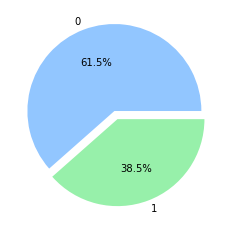

In [12]:
def check_data_balance(series, style="seaborn-pastel"):
  with plt.style.context(style):
    unique = series.value_counts()
    display(unique) #show unique value counts of the target
    plt.pie(unique, explode=[0.05]*len(unique), labels=unique.index, autopct='%1.1f%%'); #plot a pie chart for the target to see if data are balanced

check_data_balance(data["TARGET"])

The data seems to be slightly unbalanced, but not a significant amount.

**EXPLORATORY DATA ANALYSIS**

*Sorting the Dtypes*

In [13]:
#sort by dtype

dep_var = ['TARGET']

categorical_vars = ['STREET1','STREET2','OFFSET','ROAD_CLASS','DISTRICT','LOCCOORD','ACCLOC','TRAFFCTL','VISIBILITY','LIGHT','RDSFCOND','IMPACTYPE','INVTYPE','INVAGE','INJURY','INITDIR','VEHTYPE','MANOEUVER','DRIVACT','DRIVCOND','PEDTYPE','PEDACT','PEDCOND','CYCLISTYPE','CYCCOND','PEDESTRIAN','CYCLIST','AUTOMOBILE','MOTORCYCLE','TRUCK','TRSN_CITY_VEH','EMERG_VEH','PASSENGER','SPEEDING','AG_DRIV','REDLIGHT','ALCOHOL','DISABILITY','POLICE_DIVISION','NEIGHBOURHOOD','geometry']

discrete_vars = ['ACCNUM','YEAR','DATE','TIME','HOUR','WARDNUM','DIVISION','FATAL_NO','HOOD_ID','ObjectId']


Sorting some of the variables for EDA.

Quantitative features

In [14]:
data.loc[:, dep_var + discrete_vars + categorical_vars ].describe()

,TARGET,ACCNUM,YEAR,TIME,HOUR,HOOD_ID,ObjectId
count,16860.000000,1.686000e+04,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000
mean,0.384875,2.263460e+09,2012.256168,1352.106821,13.241103,74.003618,8430.500000
std,0.486580,3.263836e+09,4.252797,629.726747,6.302679,41.411541,4867.207105
min,0.000000,2.530100e+04,2006.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,1.065135e+06,2009.000000,913.000000,9.000000,39.000000,4215.750000
50%,0.000000,1.293196e+06,2012.000000,1442.000000,14.000000,77.000000,8430.500000
75%,1.000000,5.001806e+09,2016.000000,1845.000000,18.000000,112.000000,12645.250000
max,1.000000,9.085345e+09,2020.000000,2359.000000,23.000000,140.000000,16860.000000


The average of fatal/major incidents is 38.49%.

Correlation Analysis

In [15]:
corr_matrix = data.loc[:, dep_var +  discrete_vars].corr(method='pearson')

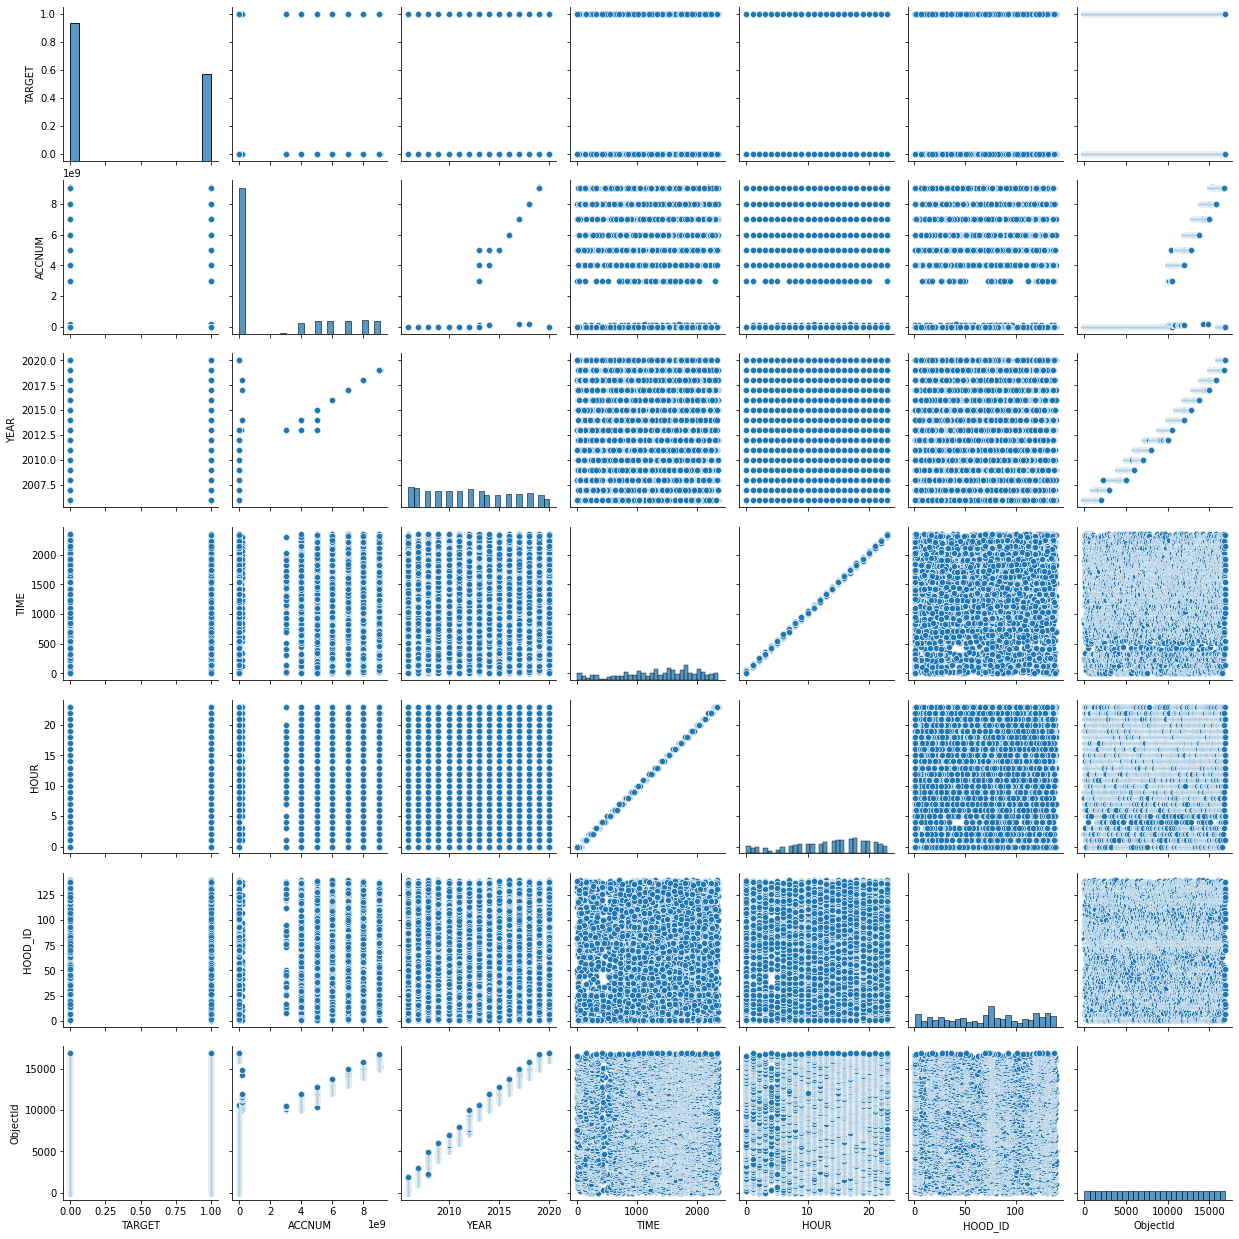

In [16]:
sns.pairplot(data=data.loc[:, dep_var + categorical_vars + discrete_vars])
plt.show()

In [17]:
correlation = data.corr()
correlation['TARGET'].sort_values(ascending=False)

TARGET      1.000000
ObjectId    0.053095
YEAR        0.052820
ACCNUM      0.046429
HOOD_ID     0.006643
HOUR       -0.007863
TIME       -0.007974
Name: TARGET, dtype: float64

A correlation matrix is a table containing correlation coefficients between variables. Each cell in the table represents the correlation between two variables. The value lies between -1 and 1. A correlation matrix is used to summarize data, as a diagnostic for advanced analyses and as an input into a more advanced analysis. The two key components of the correlation are:

Magnitude: larger the magnitude, stronger the correlation.
Sign: if positive, there is a regular correlation. If negative, there is an inverse correlation. None of the variables have a particularly strong correlation with the target variable.

**Categorical Variables**

*Season vs. Target*

In [18]:
def seasons(s):
    if s[5:7] in ['01', '02', '12']:
        return('Winter')
    if s[5:7] in ['03', '04', '05']:
        return('Spring')
    if s[5:7] in ['06', '07', '08']:
        return('Summer')
    return('Fall')

data['Season'] = data.DATE.apply(seasons)
data.head()

,ACCNUM,YEAR,DATE,TIME,HOUR,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,...,REDLIGHT,ALCOHOL,DISABILITY,POLICE_DIVISION,HOOD_ID,NEIGHBOURHOOD,ObjectId,geometry,TARGET,Season
_id,,,,,,,,,,,,,,,,,,,,,
1,892658,2006,2006-03-11T00:00:00,852,8,BLOOR ST W,DUNDAS ST W,None,Major Arterial,Toronto and East York,...,No,No,No,D11,88,High Park North (88),1,"{'type': 'Point', 'coordinates': (-79.45249, 4...",0,Spring
2,892658,2006,2006-03-11T00:00:00,852,8,BLOOR ST W,DUNDAS ST W,None,Major Arterial,Toronto and East York,...,No,No,No,D11,88,High Park North (88),2,"{'type': 'Point', 'coordinates': (-79.45249, 4...",1,Spring
3,892810,2006,2006-03-11T00:00:00,915,9,MORNINGSIDE AVE,SHEPPARD AVE E,None,Major Arterial,Scarborough,...,Yes,No,No,D42,131,Rouge (131),3,"{'type': 'Point', 'coordinates': (-79.199786, ...",1,Spring
4,892810,2006,2006-03-11T00:00:00,915,9,MORNINGSIDE AVE,SHEPPARD AVE E,None,Major Arterial,Scarborough,...,Yes,No,No,D42,131,Rouge (131),4,"{'type': 'Point', 'coordinates': (-79.199786, ...",0,Spring
5,892682,2006,2006-03-12T00:00:00,240,2,EGLINTON AVE E,COMMONWEALTH AVE,None,Major Arterial,Scarborough,...,No,Yes,No,D41,138,Eglinton East (138),5,"{'type': 'Point', 'coordinates': (-79.25619, 4...",0,Spring


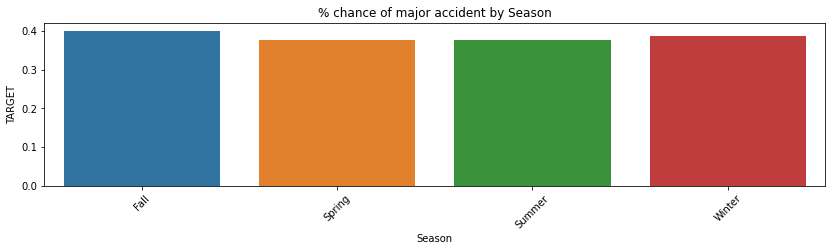

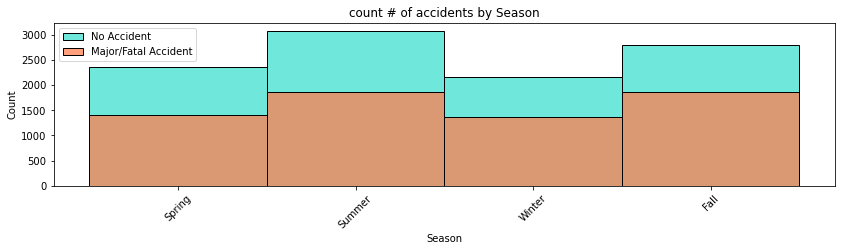

In [19]:
plt.figure(figsize=(14,3))

data_var = data.groupby('Season')['TARGET'].mean().reset_index()
sns.barplot(x = data_var.Season, y = data_var['TARGET'])
plt.title('% chance of major accident by Season')
plt.xticks(rotation = 45)
plt.show()


plt.figure(figsize = (14, 3))
sns.histplot(data.query('TARGET == 0')['Season'], color = 'turquoise', kde = False, label = 'No Accident')
sns.histplot(data.query('TARGET == 1')['Season'], color = 'coral', kde = False, label = 'Major/Fatal Accident')
plt.legend()
plt.xticks(rotation = 45)
plt.title('count # of accidents by Season')
plt.show()

A histogram is a classic visualization tool that represents the distribution of one or more variables by counting the number of observations that fall within disrete bins.

The probability of a fatal/major incidents seems to be higher during the winter/fall months. In terms of counts, there seems to be more major/fatal accidents in the  Summer and Fall.

*Month vs.Target*

In [20]:
data['Month'] = data.DATE.apply(lambda x: int(x[5:7]))
data.head()

,ACCNUM,YEAR,DATE,TIME,HOUR,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,...,ALCOHOL,DISABILITY,POLICE_DIVISION,HOOD_ID,NEIGHBOURHOOD,ObjectId,geometry,TARGET,Season,Month
_id,,,,,,,,,,,,,,,,,,,,,
1,892658,2006,2006-03-11T00:00:00,852,8,BLOOR ST W,DUNDAS ST W,None,Major Arterial,Toronto and East York,...,No,No,D11,88,High Park North (88),1,"{'type': 'Point', 'coordinates': (-79.45249, 4...",0,Spring,3
2,892658,2006,2006-03-11T00:00:00,852,8,BLOOR ST W,DUNDAS ST W,None,Major Arterial,Toronto and East York,...,No,No,D11,88,High Park North (88),2,"{'type': 'Point', 'coordinates': (-79.45249, 4...",1,Spring,3
3,892810,2006,2006-03-11T00:00:00,915,9,MORNINGSIDE AVE,SHEPPARD AVE E,None,Major Arterial,Scarborough,...,No,No,D42,131,Rouge (131),3,"{'type': 'Point', 'coordinates': (-79.199786, ...",1,Spring,3
4,892810,2006,2006-03-11T00:00:00,915,9,MORNINGSIDE AVE,SHEPPARD AVE E,None,Major Arterial,Scarborough,...,No,No,D42,131,Rouge (131),4,"{'type': 'Point', 'coordinates': (-79.199786, ...",0,Spring,3
5,892682,2006,2006-03-12T00:00:00,240,2,EGLINTON AVE E,COMMONWEALTH AVE,None,Major Arterial,Scarborough,...,Yes,No,D41,138,Eglinton East (138),5,"{'type': 'Point', 'coordinates': (-79.25619, 4...",0,Spring,3


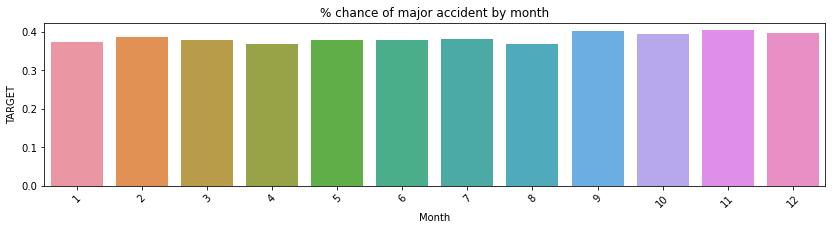

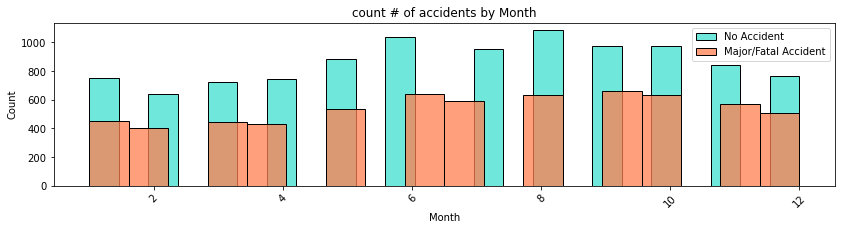

In [21]:
plt.figure(figsize=(14,3))

data_var = data.groupby('Month')['TARGET'].mean().reset_index()
sns.barplot(x = data_var.Month, y = data_var['TARGET'])
plt.title('% chance of major accident by month')
plt.xticks(rotation = 45)
plt.show()


plt.figure(figsize = (14, 3))
sns.histplot(data.query('TARGET == 0')['Month'], color = 'turquoise', kde = False, label = 'No Accident')
sns.histplot(data.query('TARGET == 1')['Month'], color = 'coral', kde = False, label = 'Major/Fatal Accident')
plt.legend()
plt.xticks(rotation = 45)
plt.title('count # of accidents by Month')
plt.show()


The probability of a fatal/major incidents seems to be higher during the fall/winter months (September to December). August had the lowest probability. In terms of counts there seems to be a large number of fatal/major incidents that occur through Summer/fall. 

*Hour vs. Target*

In [22]:
data.DATE = pd.to_datetime(data.DATE)
data.head()

,ACCNUM,YEAR,DATE,TIME,HOUR,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,...,ALCOHOL,DISABILITY,POLICE_DIVISION,HOOD_ID,NEIGHBOURHOOD,ObjectId,geometry,TARGET,Season,Month
_id,,,,,,,,,,,,,,,,,,,,,
1,892658,2006,2006-03-11,852,8,BLOOR ST W,DUNDAS ST W,None,Major Arterial,Toronto and East York,...,No,No,D11,88,High Park North (88),1,"{'type': 'Point', 'coordinates': (-79.45249, 4...",0,Spring,3
2,892658,2006,2006-03-11,852,8,BLOOR ST W,DUNDAS ST W,None,Major Arterial,Toronto and East York,...,No,No,D11,88,High Park North (88),2,"{'type': 'Point', 'coordinates': (-79.45249, 4...",1,Spring,3
3,892810,2006,2006-03-11,915,9,MORNINGSIDE AVE,SHEPPARD AVE E,None,Major Arterial,Scarborough,...,No,No,D42,131,Rouge (131),3,"{'type': 'Point', 'coordinates': (-79.199786, ...",1,Spring,3
4,892810,2006,2006-03-11,915,9,MORNINGSIDE AVE,SHEPPARD AVE E,None,Major Arterial,Scarborough,...,No,No,D42,131,Rouge (131),4,"{'type': 'Point', 'coordinates': (-79.199786, ...",0,Spring,3
5,892682,2006,2006-03-12,240,2,EGLINTON AVE E,COMMONWEALTH AVE,None,Major Arterial,Scarborough,...,Yes,No,D41,138,Eglinton East (138),5,"{'type': 'Point', 'coordinates': (-79.25619, 4...",0,Spring,3


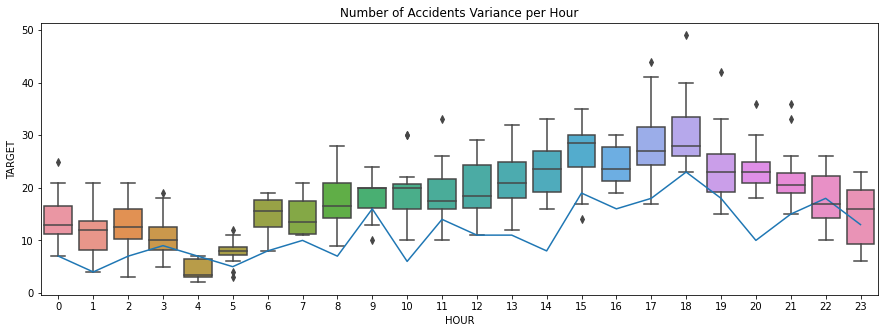

In [23]:
data = data.astype({'YEAR': 'int32'})

acc_by_year = data.groupby(['YEAR', 'HOUR']).agg({'TARGET': 'sum'}).reset_index()

plt.figure(figsize=(15, 5))
ax = sns.boxplot(data = acc_by_year.query('YEAR < 2020'), x = 'HOUR' , y = 'TARGET')
sns.lineplot(ax = ax, data = acc_by_year.query('YEAR == 2020'), x = 'HOUR', y = 'TARGET')
plt.title('Number of Accidents Variance per Hour')
plt.savefig('Number of Accidents Variance per Hour.png', bbox_inches = 'tight')
plt.show()



Boxplots are a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”).

There seems to be an increase in fatal/major incidents in the evening hours, which is evident by the increasing trend line and the higher box plots, and then it starts to level off at the end, which may be because people are sleeping. There also seems to be more significant outliers in the evening hours.

*Time of Day vs. Target*

In [24]:
data = data.astype({'HOUR': 'int32'})

def time_of_day(s):
    if (s >= 21 and s <= 23) or (s <= 6):
        return('Night')
    if s > 6 and s < 12:
        return('Morning')
    if s >= 12 and s <= 15:
        return('Afternoon')
    return('Evening')

data['TimeOfDay'] = data.HOUR.apply(time_of_day)

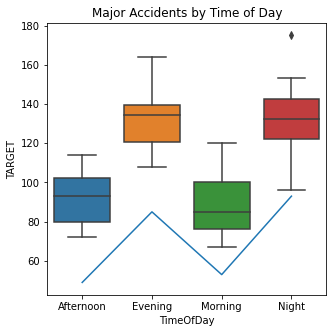

In [25]:
acc_by_time_of_day = data.groupby(['YEAR', 'TimeOfDay']).agg({'TARGET': 'sum'}).reset_index()

plt.figure(figsize=(5, 5))
ax = sns.boxplot(data = acc_by_time_of_day.query('YEAR < 2020'), x = 'TimeOfDay' , y = 'TARGET')
sns.lineplot(ax = ax, data = acc_by_time_of_day.query('YEAR == 2020'), x = 'TimeOfDay', y = 'TARGET')
plt.title('Major Accidents by Time of Day')
plt.savefig('Major Accidents by ToD.png', bbox_inches = 'tight')
plt.show()

The findings seem to to coincide with the previous chart. There are more incidents in the evening and at night. There is also an outlier at night.

*Year, Time of Day, District vs. Target*

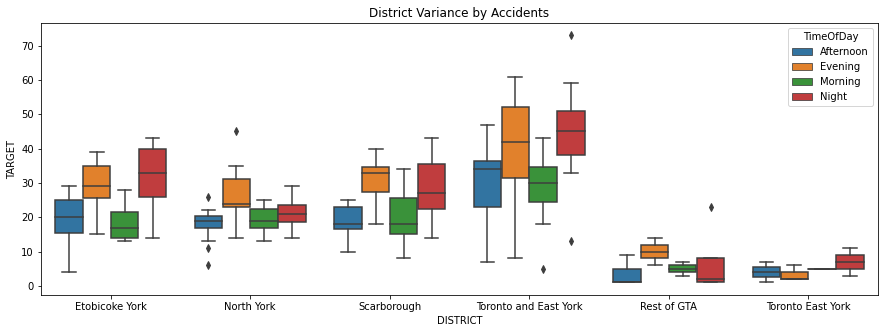

In [25]:
acc_by_district = data.groupby(['YEAR', 'TimeOfDay', 'DISTRICT']).agg({'TARGET': 'sum'}).reset_index()
               
plt.figure(figsize=(15, 5))
sns.boxplot(data = acc_by_district, x = 'DISTRICT' , y = 'TARGET', hue = 'TimeOfDay')
plt.title('District Variance by Accidents')
plt.savefig('District Variance by Accidents.png', bbox_inches = 'tight')

It appears that Toronto East York and Etobicoke have the greatest number of incidents. The box plots for evenings and nights seem to be larger than the rest. 

*Year, Time of Day, RDSFCOND vs. Target*

In [28]:
data.groupby('RDSFCOND')['TARGET'].count()

RDSFCOND
Dry                     13435
Ice                        73
Loose Sand or Gravel        7
Loose Snow                166
Other                     170
Packed Snow                42
Slush                      96
Spilled liquid              1
Wet                      2870
Name: TARGET, dtype: int64

In [29]:
data.groupby('RDSFCOND')['TARGET'].mean()

RDSFCOND
Dry                     0.382732
Ice                     0.369863
Loose Sand or Gravel    0.571429
Loose Snow              0.361446
Other                   0.423529
Packed Snow             0.404762
Slush                   0.354167
Spilled liquid          1.000000
Wet                     0.394425
Name: TARGET, dtype: float64

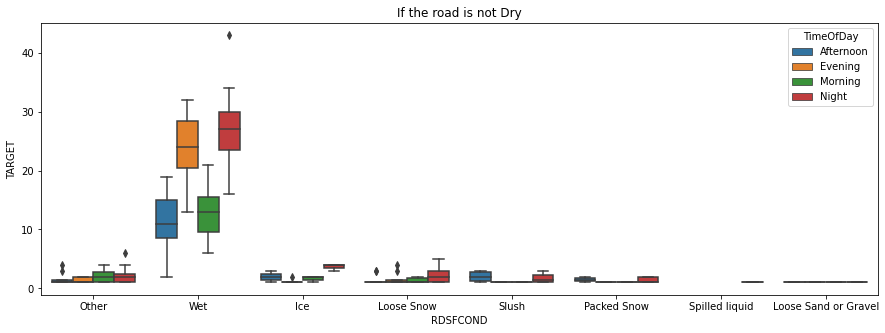

In [30]:
acc_by_roadsurf = data.groupby(['YEAR', 'TimeOfDay', 'RDSFCOND']).agg({'TARGET': 'sum'}).reset_index()
plt.figure(figsize=(15, 5))
sns.boxplot(data = acc_by_roadsurf.query('RDSFCOND != "Dry"'), x = 'RDSFCOND' , y = 'TARGET', hue = 'TimeOfDay')
plt.title('If the road is not Dry')
plt.savefig('Accidents by ToD and Road Condition.png', bbox_inches = 'tight')

In terms of counts, dry conditions had the greatest number of fatal/major incidents, followed by wet conditions. The evening and night box plots also appear to be larger than the rest, implying that wet conditions have a greater range than the other non-dry conditions.

*Year vs. Target*

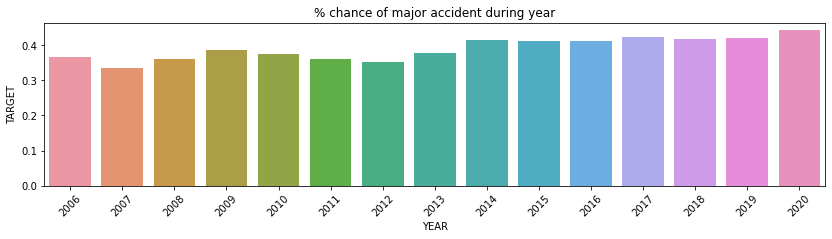

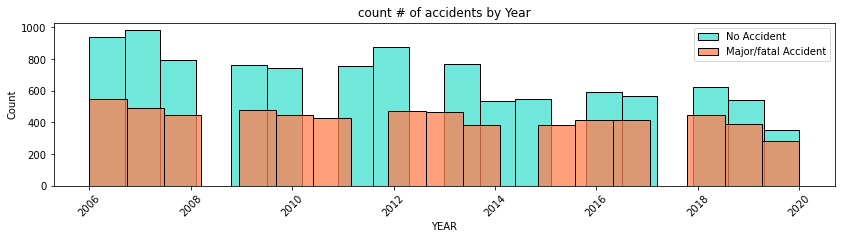

In [31]:
plt.figure(figsize=(14,3))

data_var = data.groupby('YEAR')['TARGET'].mean().reset_index()
sns.barplot(x = data_var.YEAR, y = data_var['TARGET'])
plt.title('% chance of major accident during year')
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize = (14, 3))
sns.histplot(data.query('TARGET == 0')['YEAR'], color = 'turquoise', kde = False, label = 'No Accident')
sns.histplot(data.query('TARGET == 1')['YEAR'], color = 'coral', kde = False, label = 'Major/fatal Accident')
plt.legend()
plt.xticks(rotation = 45)
plt.title('count # of accidents by Year')
plt.show()

The liklihood of fatal/major incidents seem to be steadily increasing as the years continue. But the counts themselves appear relatively steady and even somewhat decreasing.

*Visibility vs. Target*

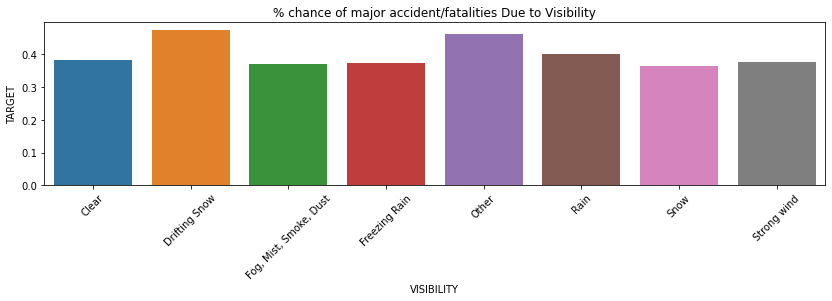

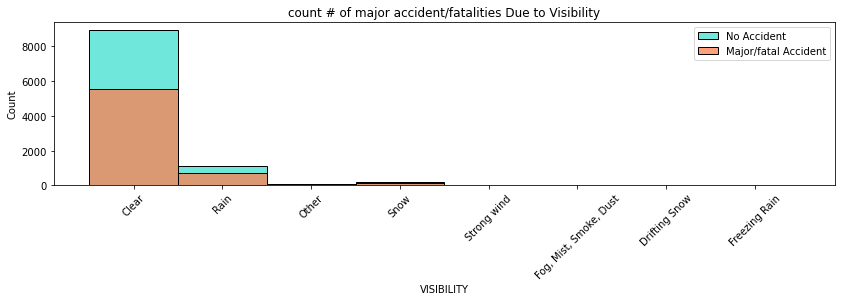

In [32]:
plt.figure(figsize=(14,3))

data_var = data.groupby('VISIBILITY')['TARGET'].mean().reset_index()
sns.barplot(x = data_var.VISIBILITY, y = data_var['TARGET'])
plt.title('% chance of major accident/fatalities Due to Visibility')
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize = (14, 3))
sns.histplot(data.query('TARGET == 0')['VISIBILITY'], color = 'turquoise', kde = False, label = 'No Accident')
sns.histplot(data.query('TARGET == 1')['VISIBILITY'], color = 'coral', kde = False, label = 'Major/fatal Accident')
plt.legend()
plt.xticks(rotation = 45)
plt.title('count # of major accident/fatalities Due to Visibility')
plt.show()


There seems to be more fatal/major incidents when there is drifting snow and rain. In terms of counts, there seems to be alot of clear conditions.

*Involvement Type vs. Target*

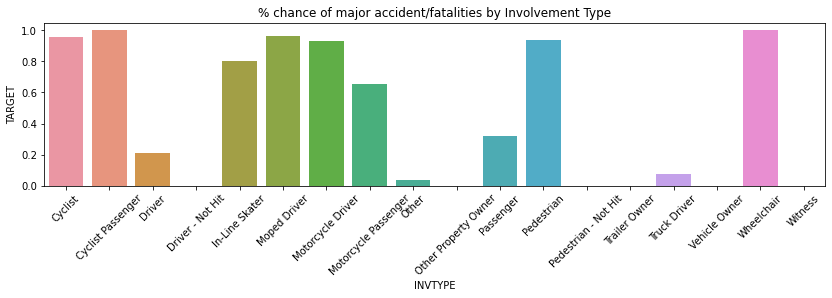

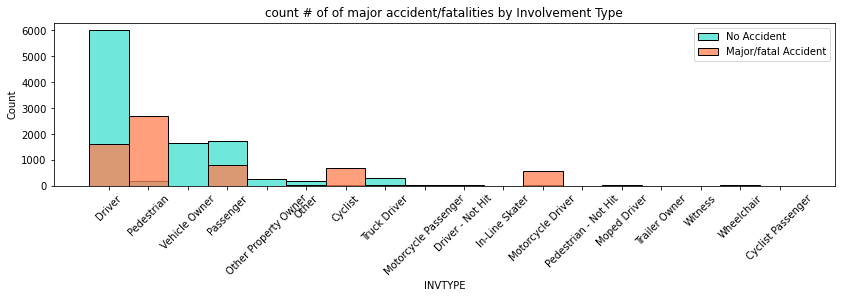

In [33]:
plt.figure(figsize=(14,3))

data_var = data.groupby('INVTYPE')['TARGET'].mean().reset_index()
sns.barplot(x = data_var.INVTYPE, y = data_var['TARGET'])
plt.title('% chance of major accident/fatalities by Involvement Type')
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize = (14, 3))
sns.histplot(data.query('TARGET == 0')['INVTYPE'], color = 'turquoise', kde = False, label = 'No Accident')
sns.histplot(data.query('TARGET == 1')['INVTYPE'], color = 'coral', kde = False, label = 'Major/fatal Accident')
plt.legend()
plt.xticks(rotation = 45)
plt.title('count # of of major accident/fatalities by Involvement Type')
plt.show()



The liklihood for major/fatal accidents seems to be higher when cyclists, cyclist passengers, wheelchairs. Followed by moped driver, motorcycle driver, and pedestrians.

*Age group of Involved Party vs.Target*

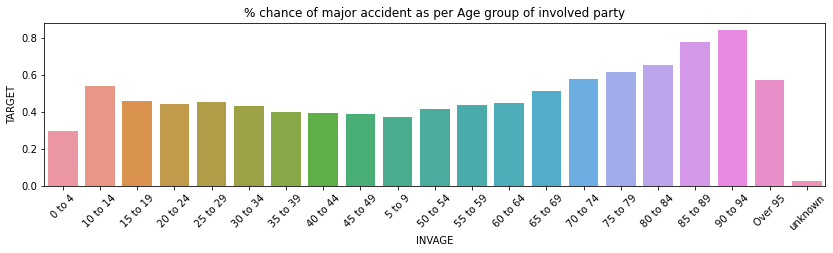

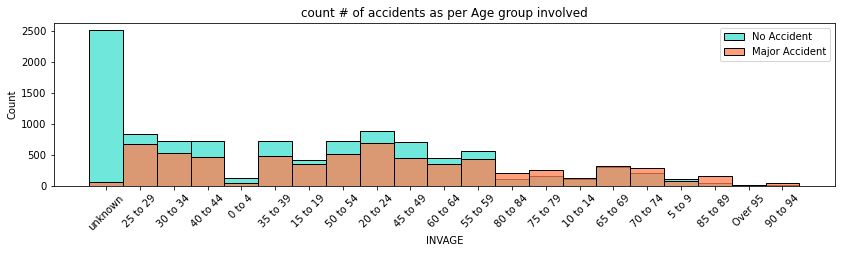

In [34]:
plt.figure(figsize=(14,3))

data_var = data.groupby('INVAGE')['TARGET'].mean().reset_index()
sns.barplot(x = data_var.INVAGE, y = data_var['TARGET'])
plt.title('% chance of major accident as per Age group of involved party')
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize = (14, 3))
sns.histplot(data.query('TARGET == 0')['INVAGE'], color = 'turquoise', kde = False, label = 'No Accident')
sns.histplot(data.query('TARGET == 1')['INVAGE'], color = 'coral', kde = False, label = 'Major Accident')
plt.legend()
plt.xticks(rotation = 45)
plt.title('count # of accidents as per Age group involved')
plt.show()

There seems to be large percentage of fatalities/major incidents involving groups 65+. Even though ages 25 to 65 seem to have higher counts.

*Vehicle Type vs. Target*

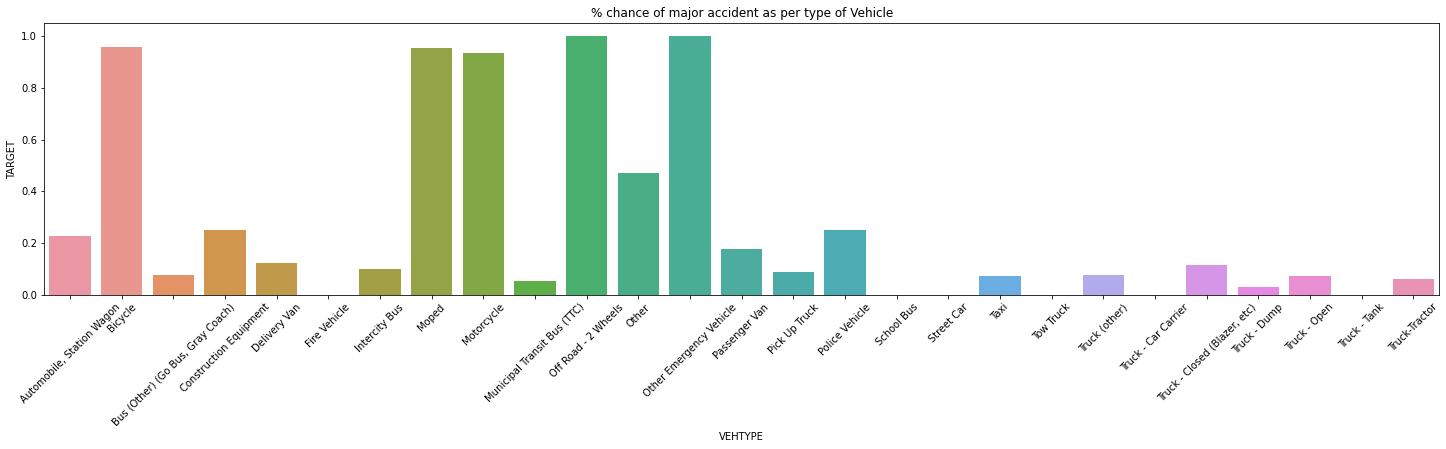

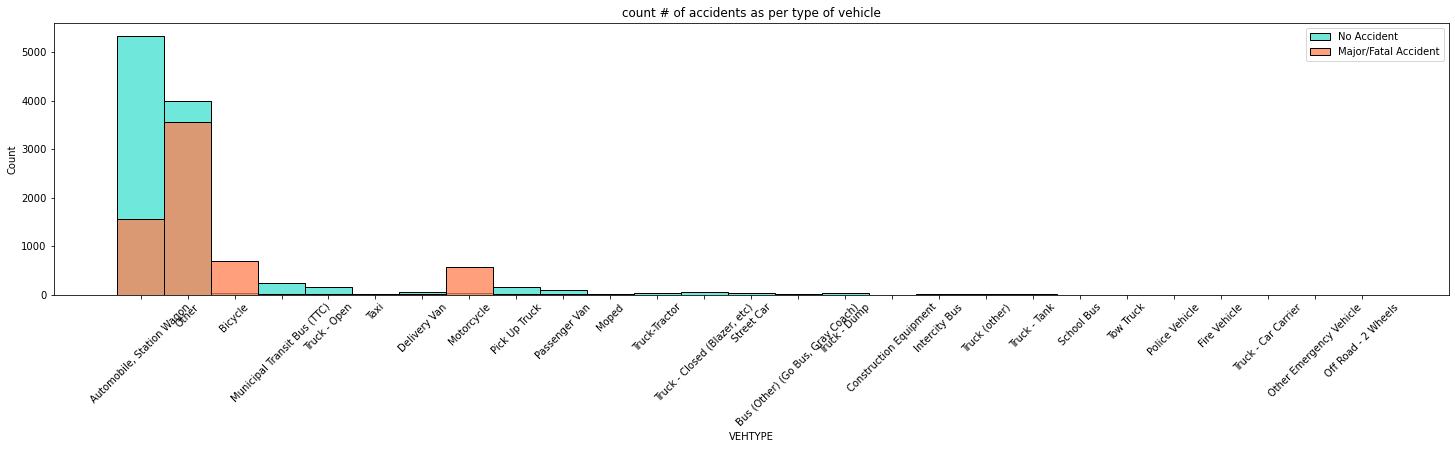

In [35]:
plt.figure(figsize=(25,5))

data_var = data.groupby('VEHTYPE')['TARGET'].mean().reset_index()
sns.barplot(x = data_var.VEHTYPE, y = data_var['TARGET'])
plt.title('% chance of major accident as per type of Vehicle')
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize = (25, 5))
sns.histplot(data.query('TARGET == 0')['VEHTYPE'], color = 'turquoise', kde = False, label = 'No Accident')
sns.histplot(data.query('TARGET == 1')['VEHTYPE'], color = 'coral', kde = False, label = 'Major/Fatal Accident')
plt.legend()
plt.xticks(rotation = 45)
plt.title('count # of accidents as per type of vehicle')
plt.show()

The probability of having a major incident/fatality seems to be higher for TTC, emergency vehicles, motor cycles, moped (which is a type of scooter), and bicycles. 

*Light vs. Target*

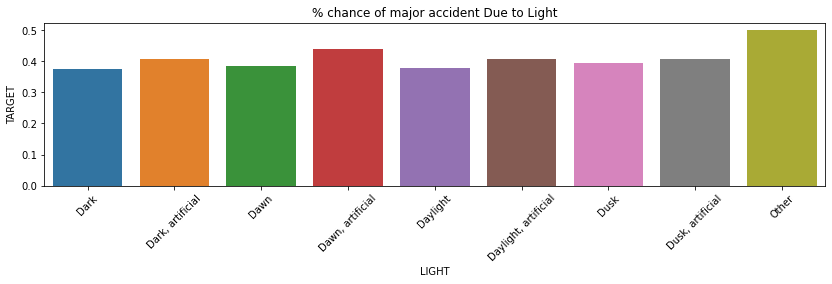

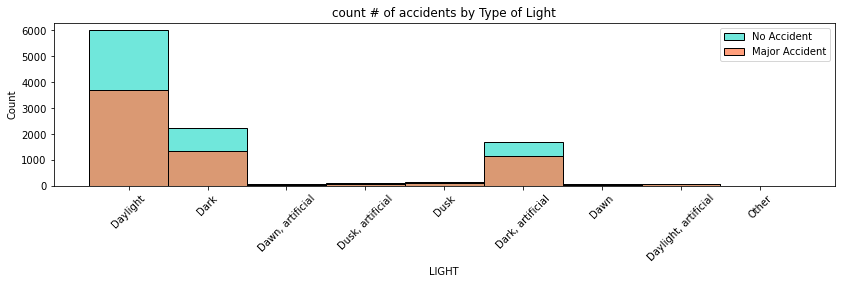

In [36]:
plt.figure(figsize=(14,3))

data_var = data.groupby('LIGHT')['TARGET'].mean().reset_index()
sns.barplot(x = data_var.LIGHT, y = data_var['TARGET'])
plt.title('% chance of major accident Due to Light')
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize = (14, 3))
sns.histplot(data.query('TARGET == 0')['LIGHT'], color = 'turquoise', kde = False, label = 'No Accident')
sns.histplot(data.query('TARGET == 1')['LIGHT'], color = 'coral', kde = False, label = 'Major Accident')
plt.legend()
plt.xticks(rotation = 45)
plt.title('count # of accidents by Type of Light')
plt.show()

The probability of having a major incident/fatality seems to be higher when its dark outside, also when its artificial dawn. 

*Traffic Light vs. Target*

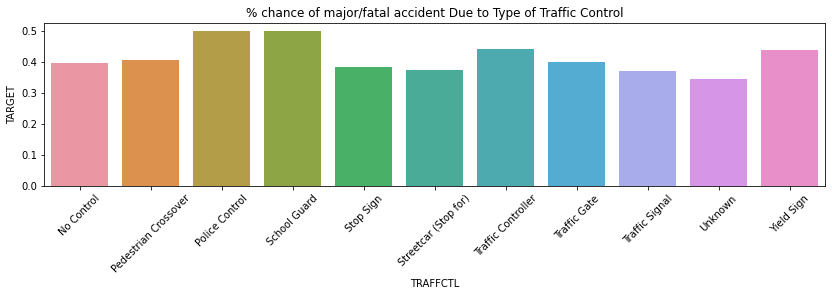

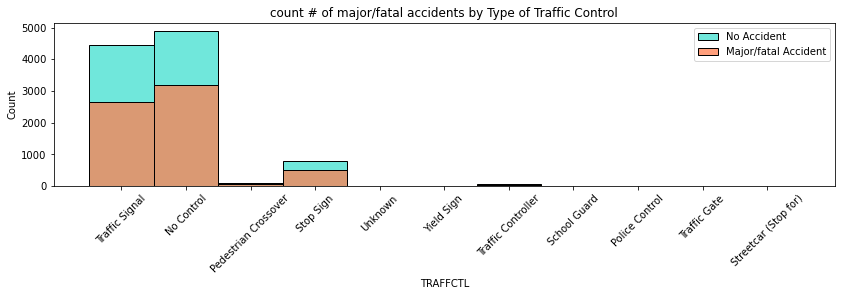

In [37]:
plt.figure(figsize=(14,3))

data_var = data.groupby('TRAFFCTL')['TARGET'].mean().reset_index()
sns.barplot(x = data_var.TRAFFCTL, y = data_var['TARGET'])
plt.title('% chance of major/fatal accident Due to Type of Traffic Control')
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize = (14, 3))
sns.histplot(data.query('TARGET == 0')['TRAFFCTL'], color = 'turquoise', kde = False, label = 'No Accident')
sns.histplot(data.query('TARGET == 1')['TRAFFCTL'], color = 'coral', kde = False, label = 'Major/fatal Accident')
plt.legend()
plt.xticks(rotation = 45)
plt.title('count # of major/fatal accidents by Type of Traffic Control')
plt.show()

The probability of having a major incident/fatality seems to be higher when there is police control and a school guard is present, which is surprising cause one would think it would be the opposite. Perhaps, the areas where a police officer and school guard are already inherently more dangerous. The yield sign also appears to have a high probability of major incident/fatality.

*Location vs. Target*

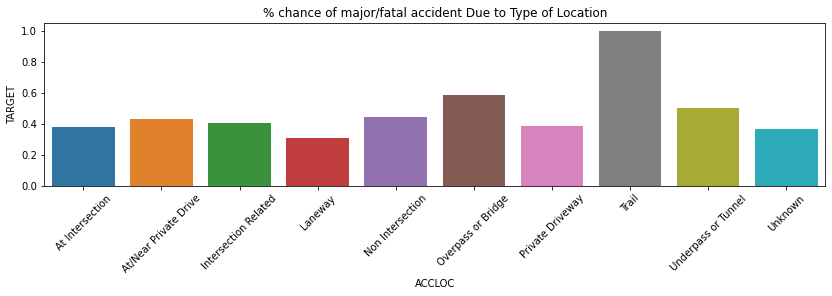

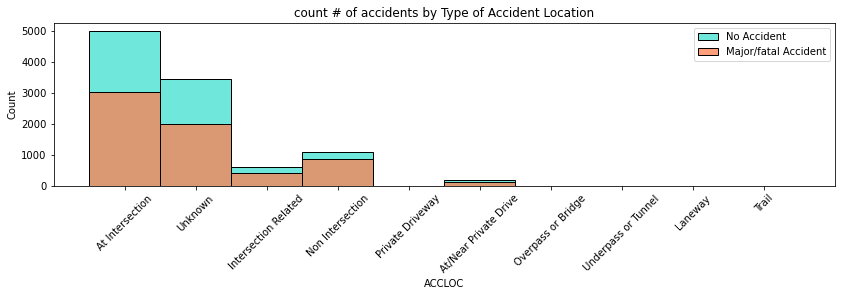

In [38]:
plt.figure(figsize=(14,3))

data_var = data.groupby('ACCLOC')['TARGET'].mean().reset_index()
sns.barplot(x = data_var.ACCLOC, y = data_var['TARGET'])
plt.title('% chance of major/fatal accident Due to Type of Location')
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize = (14, 3))
sns.histplot(data.query('TARGET == 0')['ACCLOC'], color = 'turquoise', kde = False, label = 'No Accident')
sns.histplot(data.query('TARGET == 1')['ACCLOC'], color = 'coral', kde = False, label = 'Major/fatal Accident')
plt.legend()
plt.xticks(rotation = 45)
plt.title('count # of accidents by Type of Accident Location')
plt.show()

The probability of having a major incident/fatality seems to be significantly higher when there is a trail. This may be referring to a secluded trail, where there is limited lighting.

*Direction vs. Target*

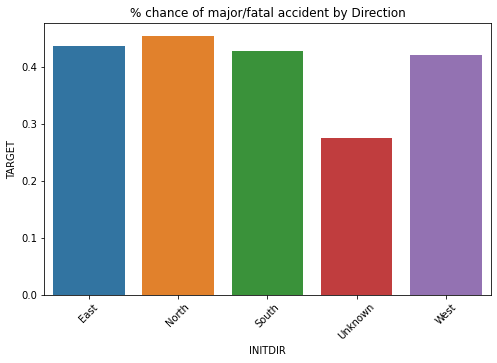

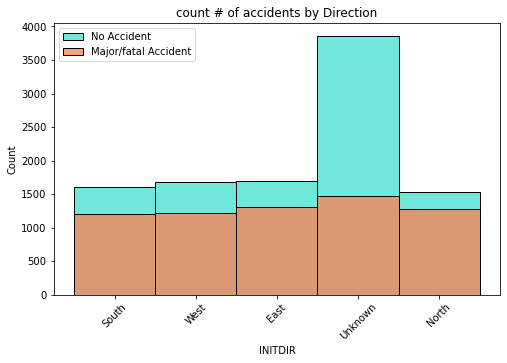

In [39]:
plt.figure(figsize=(8,5))

data_var = data.groupby('INITDIR')['TARGET'].mean().reset_index()
sns.barplot(x = data_var.INITDIR, y = data_var['TARGET'])
plt.title('% chance of major/fatal accident by Direction')
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize = (8, 5))
sns.histplot(data.query('TARGET == 0')['INITDIR'], color = 'turquoise', kde = False, label = 'No Accident')
sns.histplot(data.query('TARGET == 1')['INITDIR'], color = 'coral', kde = False, label = 'Major/fatal Accident')
plt.legend()
plt.xticks(rotation = 45)
plt.title('count # of accidents by Direction')
plt.show()

The probability of having a major incident/fatality seems to be higher when individuals are traveling North. Perhaps the weather conditions get more severe as they travel more North. There also seems to be a lot of unknowns.

*Manoeuver vs.Target*

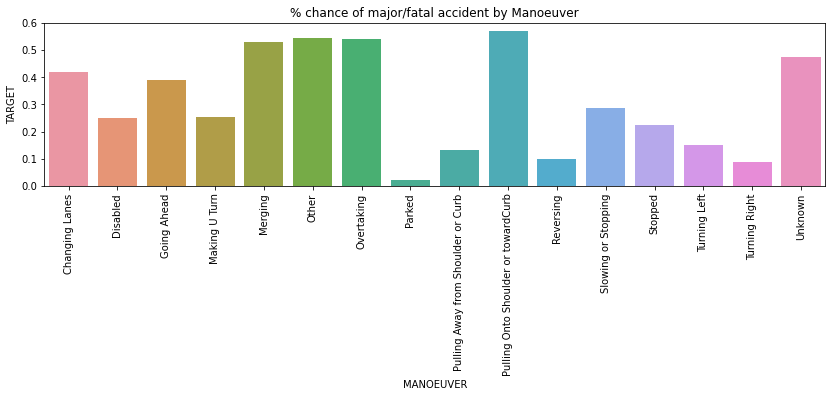

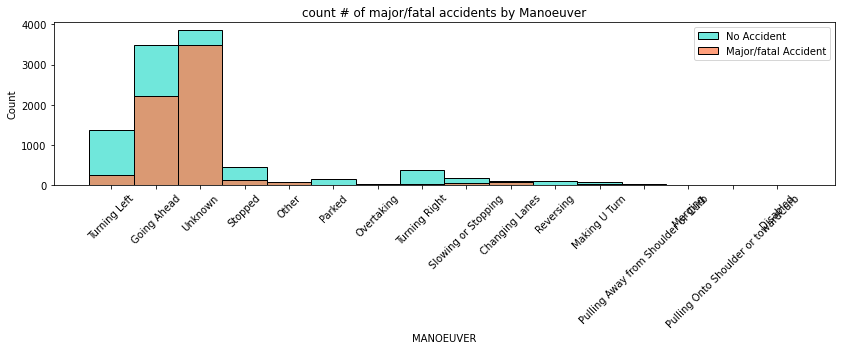

In [40]:
plt.figure(figsize=(14,3))

data_var = data.groupby('MANOEUVER')['TARGET'].mean().reset_index()
sns.barplot(x = data_var.MANOEUVER, y = data_var['TARGET'])
plt.title('% chance of major/fatal accident by Manoeuver')
plt.xticks(rotation = 90)
plt.savefig('acc by manoeuver.png', bbox_inches = 'tight')
plt.show()

plt.figure(figsize = (14, 3))
sns.histplot(data.query('TARGET == 0')['MANOEUVER'], color = 'turquoise', kde = False, label = 'No Accident')
sns.histplot(data.query('TARGET == 1')['MANOEUVER'], color = 'coral', kde = False, label = 'Major/fatal Accident')
plt.legend()
plt.xticks(rotation = 45)
plt.title('count # of major/fatal accidents by Manoeuver')
plt.show()

The probability of having a major incident/fatality seems to be higher when individuals are pulling onto shoulder, overtaking, and merging.

*Driver Action vs. Target*

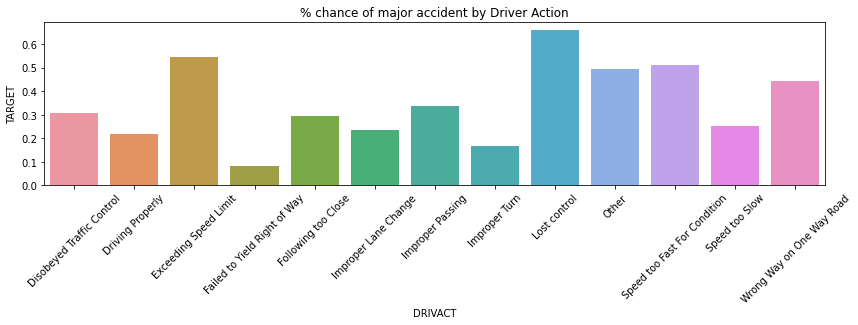

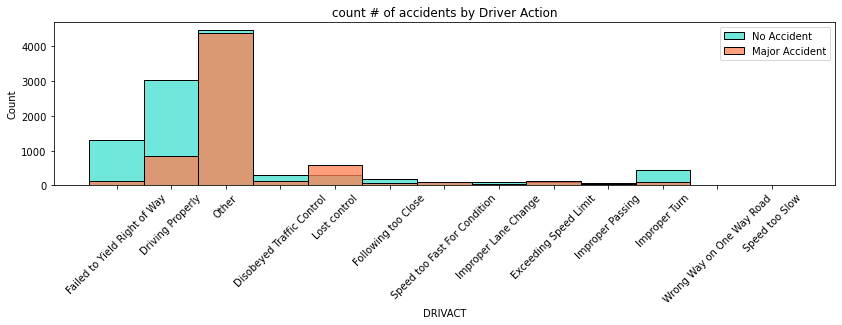

In [41]:
plt.figure(figsize=(14,3))

data_var = data.groupby('DRIVACT')['TARGET'].mean().reset_index()
sns.barplot(x = data_var.DRIVACT, y = data_var['TARGET'])
plt.title('% chance of major accident by Driver Action')
plt.xticks(rotation = 45)
plt.savefig('acc by driver action.png', bbox_inches = 'tight')
plt.show()

plt.figure(figsize = (14, 3))
sns.histplot(data.query('TARGET == 0')['DRIVACT'], color = 'turquoise', kde = False, label = 'No Accident')
sns.histplot(data.query('TARGET == 1')['DRIVACT'], color = 'coral', kde = False, label = 'Major Accident')
plt.legend()
plt.xticks(rotation = 45)
plt.title('count # of accidents by Driver Action')
plt.show()

The probability of having a major incident/fatality seems to be higher when the driver has lost control or exceeeded speed limit. In terms of counts, it looks like most drivers in this dataset drive properly or other.

*Driver Condition vs. Target*

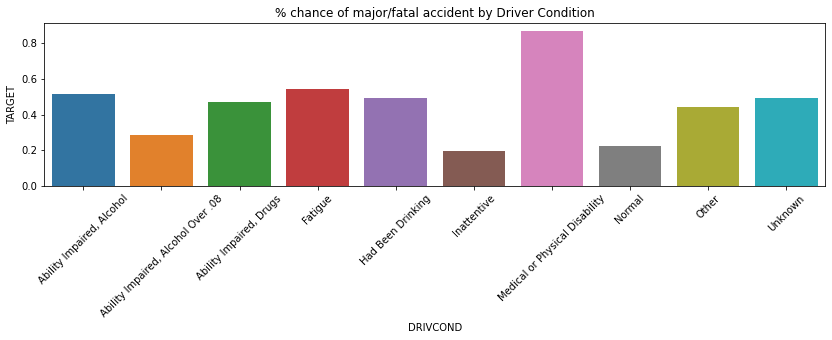

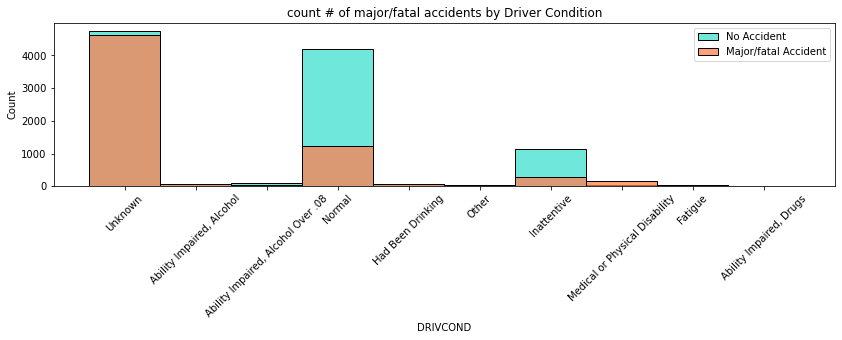

In [42]:
plt.figure(figsize=(14,3))

data_var = data.groupby('DRIVCOND')['TARGET'].mean().reset_index()
sns.barplot(x = data_var.DRIVCOND, y = data_var['TARGET'])
plt.title('% chance of major/fatal accident by Driver Condition')
plt.xticks(rotation = 45)
plt.savefig('chance of major fatal acc by driver cond.png', bbox_inches = 'tight')
plt.show()

plt.figure(figsize = (14, 3))
sns.histplot(data.query('TARGET == 0')['DRIVCOND'], color = 'turquoise', kde = False, label = 'No Accident')
sns.histplot(data.query('TARGET == 1')['DRIVCOND'], color = 'coral', kde = False, label = 'Major/fatal Accident')
plt.legend()
plt.xticks(rotation = 45)
plt.title('count # of major/fatal accidents by Driver Condition')
plt.show()

The probability of having a major incident/fatality seems to be higher when the driver has medical or physical disability. Fatigue and alcohol impairement appear to also be significant. In terms of counts, there seems to be a lot of unknowns, and normal driving.

*Pedestrian Condition vs. Target*

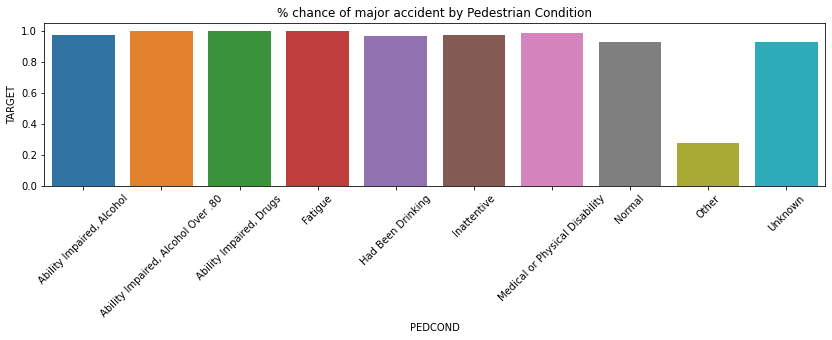

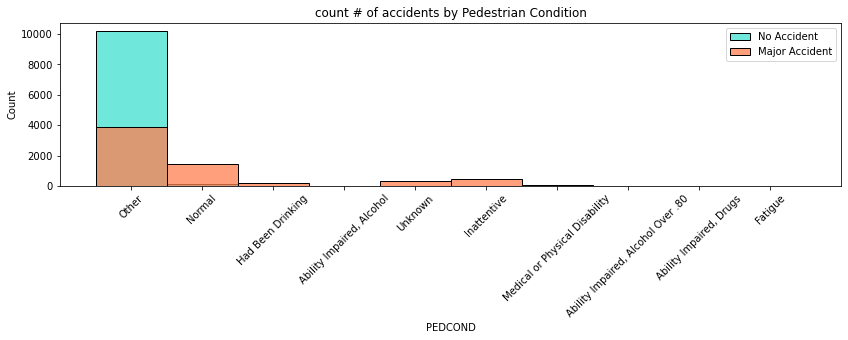

In [43]:
plt.figure(figsize=(14,3))

data_var = data.groupby('PEDCOND')['TARGET'].mean().reset_index()
sns.barplot(x = data_var.PEDCOND, y = data_var['TARGET'])
plt.title('% chance of major accident by Pedestrian Condition')
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize = (14, 3))
sns.histplot(data.query('TARGET == 0')['PEDCOND'], color = 'turquoise', kde = False, label = 'No Accident')
sns.histplot(data.query('TARGET == 1')['PEDCOND'], color = 'coral', kde = False, label = 'Major Accident')
plt.legend()
plt.xticks(rotation = 45)
plt.title('count # of accidents by Pedestrian Condition')
plt.show()

The probability of having a major incident/fatality seems to be pretty consistent among the pedestrian conditions. Alcohol, drugs, and fatigue appear to be slightly higher than the rest.

*Cyclist Action vs. Target*

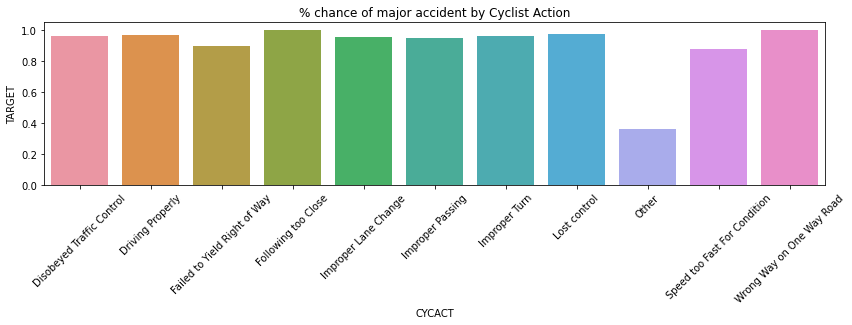

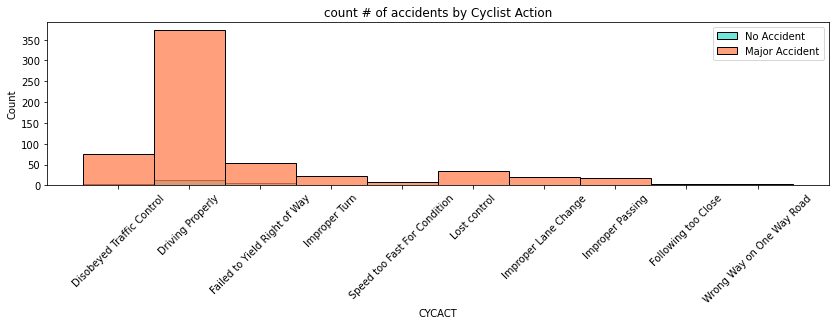

In [44]:
plt.figure(figsize=(14,3))

data_var = data.groupby('CYCACT')['TARGET'].mean().reset_index()
sns.barplot(x = data_var.CYCACT, y = data_var['TARGET'])
plt.title('% chance of major accident by Cyclist Action')
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize = (14, 3))
sns.histplot(data.query('TARGET == 0 and CYCACT != "Other"')['CYCACT'], color = 'turquoise', kde = False, label = 'No Accident')
sns.histplot(data.query('TARGET == 1 and CYCACT != "Other"')['CYCACT'], color = 'coral', kde = False, label = 'Major Accident')
plt.legend()
plt.xticks(rotation = 45)
plt.title('count # of accidents by Cyclist Action')
plt.show()

The probability of having a major incident/fatality seems to be higher when a cycalist is following too close or went the wrong way or onto a one way road. In terms of counts, there seems to be a significant number of cyclists driving properly.

*Pedestrian vs. Target*

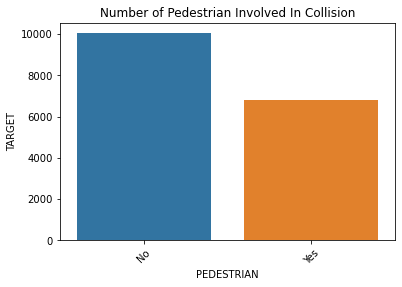

In [45]:
data_var = data.groupby('PEDESTRIAN')['TARGET'].count().reset_index()
sns.barplot(x = data_var.PEDESTRIAN, y = data_var['TARGET'])
plt.title('Number of Pedestrian Involved In Collision')
plt.xticks(rotation = 45)
plt.show()

In [46]:
data.groupby('PEDESTRIAN')['TARGET'].mean()

PEDESTRIAN
No     0.369281
Yes    0.407793
Name: TARGET, dtype: float64

The probability of having a major incident/fatality seems to be higher when there is a pedestrian involved.

Cyclist vs. Target

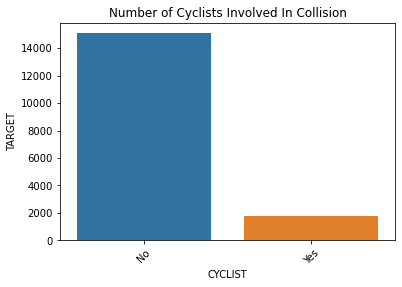

In [47]:
data_var = data.groupby('CYCLIST')['TARGET'].count().reset_index()
sns.barplot(x = data_var.CYCLIST, y = data_var['TARGET'])
plt.title('Number of Cyclists Involved In Collision')
plt.xticks(rotation = 45)
plt.show()

In [48]:
data.groupby('CYCLIST')['TARGET'].mean()

CYCLIST
No     0.379948
Yes    0.426644
Name: TARGET, dtype: float64

The probability of having a major incident/fatality seems to be higher when there is a cyclist involved. 

*Automobile vs. Target*

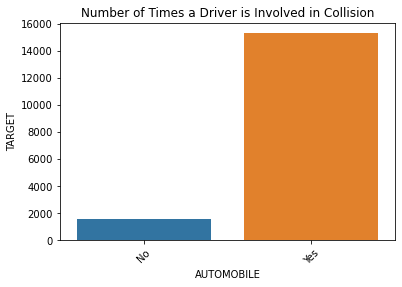

In [49]:
data_var = data.groupby('AUTOMOBILE')['TARGET'].count().reset_index()
sns.barplot(x = data_var.AUTOMOBILE, y = data_var['TARGET'])
plt.title('Number of Times a Driver is Involved in Collision')
plt.xticks(rotation = 45)
plt.show()

In [50]:
data.groupby('AUTOMOBILE')['TARGET'].mean()

AUTOMOBILE
No     0.445876
Yes    0.378691
Name: TARGET, dtype: float64

The probability of having a major incident/fatality seems to be higher when there is no automobile involved. Perhaps this is because other vehicles are more common. 

*Motorcycle vs. Target*

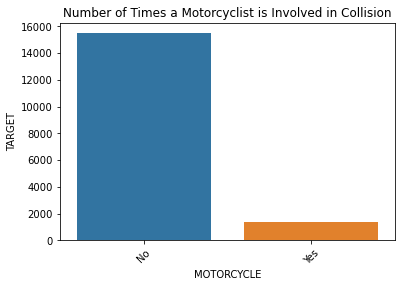

In [51]:
data_var = data.groupby('MOTORCYCLE')['TARGET'].count().reset_index()
sns.barplot(x = data_var.MOTORCYCLE, y = data_var['TARGET'])
plt.title('Number of Times a Motorcyclist is Involved in Collision')
plt.xticks(rotation = 45)
plt.show()

In [52]:
data.groupby('MOTORCYCLE')['TARGET'].mean()

MOTORCYCLE
No     0.378392
Yes    0.457370
Name: TARGET, dtype: float64

The probability of having a major incident/fatality seems to be higher when there is a motorcycle involved.

*Truck vs. Target*

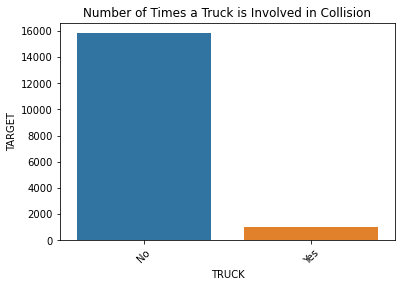

In [53]:
data_var = data.groupby('TRUCK')['TARGET'].count().reset_index()
sns.barplot(x = data_var.TRUCK, y = data_var['TARGET'])
plt.title('Number of Times a Truck is Involved in Collision')
plt.xticks(rotation = 45)
plt.show()

In [54]:
data.groupby('TRUCK')['TARGET'].mean()

TRUCK
No     0.388798
Yes    0.325336
Name: TARGET, dtype: float64

The probability seems higher when there is no truck involved.

*Transit City Vehicle vs. Target*

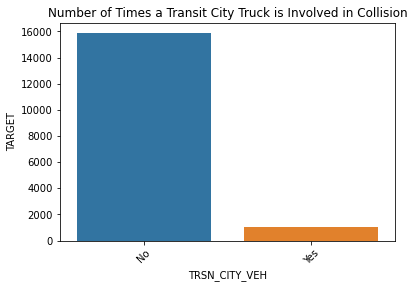

In [55]:
data_var = data.groupby('TRSN_CITY_VEH')['TARGET'].count().reset_index()
sns.barplot(x = data_var.TRSN_CITY_VEH, y = data_var['TARGET'])
plt.title('Number of Times a Transit City Truck is Involved in Collision')
plt.xticks(rotation = 45)
plt.show()

In [56]:
data.groupby('TRSN_CITY_VEH')['TARGET'].mean()

TRSN_CITY_VEH
No     0.388289
Yes    0.331355
Name: TARGET, dtype: float64

The probability seems higher when there is no transit city truck involved. 

*Emergency Vehicle vs. Target*

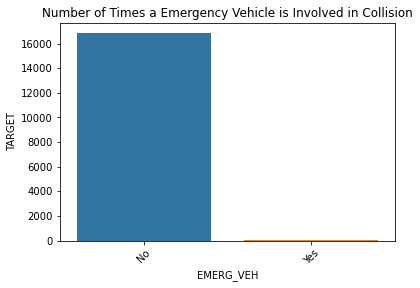

In [57]:
data_var = data.groupby('EMERG_VEH')['TARGET'].count().reset_index()
sns.barplot(x = data_var.EMERG_VEH, y = data_var['TARGET'])
plt.title('Number of Times a Emergency Vehicle is Involved in Collision')
plt.xticks(rotation = 45)
plt.show()

In [58]:
data.groupby('EMERG_VEH')['TARGET'].mean()

EMERG_VEH
No     0.385109
Yes    0.258065
Name: TARGET, dtype: float64

The probability seems higher when there is no emergency vehicle involved. 

*Passenger vs. Target*

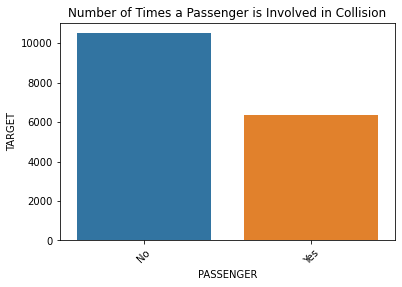

In [59]:
data_var = data.groupby('PASSENGER')['TARGET'].count().reset_index()
sns.barplot(x = data_var.PASSENGER, y = data_var['TARGET'])
plt.title('Number of Times a Passenger is Involved in Collision')
plt.xticks(rotation = 45)
plt.show()

In [60]:
data.groupby('PASSENGER')['TARGET'].mean()

PASSENGER
No     0.442084
Yes    0.290475
Name: TARGET, dtype: float64

The probability seems higher when there is no passenger involved. 

*Speeding vs. Target*

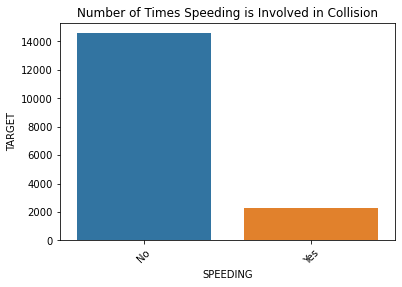

In [166]:
data_var = data.groupby('SPEEDING')['TARGET'].count().reset_index()
sns.barplot(x = data_var.SPEEDING, y = data_var['TARGET'])
plt.title('Number of Times Speeding is Involved in Collision')
plt.xticks(rotation = 45)
plt.show()

In [62]:
data.groupby('SPEEDING')['TARGET'].mean()

SPEEDING
No     0.386827
Yes    0.372429
Name: TARGET, dtype: float64

The probability seems higher when there is no speeding involved. The discrepancy with previous EDA is most likely due to the low counts of "yes".

*Aggressive and Distracted Driver vs. Target*

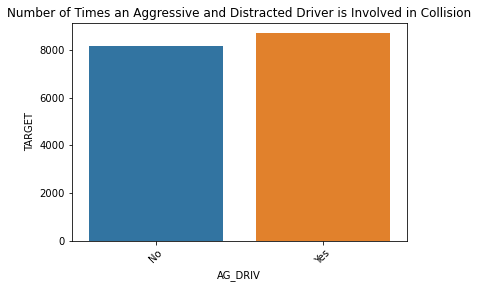

In [63]:
data_var = data.groupby('AG_DRIV')['TARGET'].count().reset_index()
sns.barplot(x = data_var.AG_DRIV, y = data_var['TARGET'])
plt.title('Number of Times an Aggressive and Distracted Driver is Involved in Collision')
plt.xticks(rotation = 45)
plt.show()

In [64]:
data.groupby('AG_DRIV')['TARGET'].mean()

AG_DRIV
No     0.400760
Yes    0.369987
Name: TARGET, dtype: float64

The probability seems higher when there is no aggressive and distracted driver involved. 

*Redlight vs. Target*

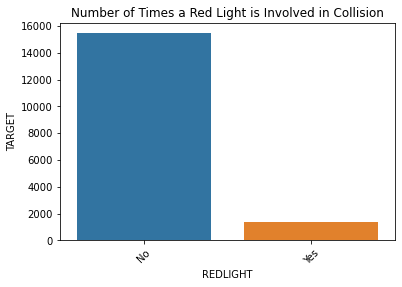

In [65]:
data_var = data.groupby('REDLIGHT')['TARGET'].count().reset_index()
sns.barplot(x = data_var.REDLIGHT, y = data_var['TARGET'])
plt.title('Number of Times a Red Light is Involved in Collision')
plt.xticks(rotation = 45)
plt.show()

In [66]:
data.groupby('REDLIGHT')['TARGET'].mean()

REDLIGHT
No     0.391172
Yes    0.315827
Name: TARGET, dtype: float64

The probability seems higher when there is no red light involved. 

Alcohol vs. Target

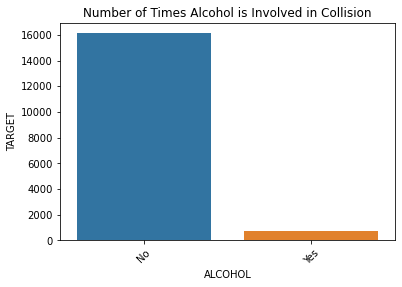

In [67]:
data_var = data.groupby('ALCOHOL')['TARGET'].count().reset_index()
sns.barplot(x = data_var.ALCOHOL, y = data_var['TARGET'])
plt.title('Number of Times Alcohol is Involved in Collision')
plt.xticks(rotation = 45)
plt.show()

In [68]:
data.groupby('ALCOHOL')['TARGET'].mean()

ALCOHOL
No     0.384778
Yes    0.387009
Name: TARGET, dtype: float64

The probability seems higher when there is alcohol involved.

*Medical or Physical Disability vs. Target*

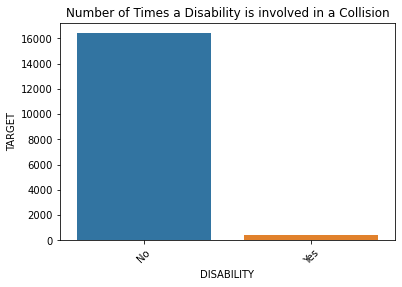

In [69]:
data_var = data.groupby('DISABILITY')['TARGET'].count().reset_index()
sns.barplot(x = data_var.DISABILITY, y = data_var['TARGET'])
plt.title('Number of Times a Disability is involved in a Collision')
plt.xticks(rotation = 45)
plt.show()

In [70]:
data.groupby('DISABILITY')['TARGET'].mean()

DISABILITY
No     0.384883
Yes    0.384615
Name: TARGET, dtype: float64

The probability seems higher when there is no disability involved. The discrepancy with previous EDA is most likely due to the low counts of "yes" values.

# Machine Learning Model

In [26]:
data.DATE = pd.to_datetime(data.DATE)
data = data.astype({'HOUR': 'int32'})
data = data.astype({'YEAR': 'int32'})
data[['ACCNUM', 'TIME',  'HOOD_ID', 'ObjectId']] = data[['ACCNUM', 'TIME',  'HOOD_ID', 'ObjectId']].apply(pd.to_numeric)

In [27]:
data.dtypes

ACCNUM                      int64
YEAR                        int32
DATE               datetime64[ns]
TIME                        int64
HOUR                        int32
STREET1                    object
STREET2                    object
OFFSET                     object
ROAD_CLASS                 object
DISTRICT                   object
WARDNUM                    object
DIVISION                   object
LOCCOORD                   object
ACCLOC                     object
TRAFFCTL                   object
VISIBILITY                 object
LIGHT                      object
RDSFCOND                   object
ACCLASS                    object
IMPACTYPE                  object
INVTYPE                    object
INVAGE                     object
INJURY                     object
FATAL_NO                   object
INITDIR                    object
VEHTYPE                    object
MANOEUVER                  object
DRIVACT                    object
DRIVCOND                   object
PEDTYPE       

**Avoiding Data Leakage**

In [28]:
data.drop("ACCLASS", axis=1, inplace=True)

In [29]:
data.drop("INJURY", axis=1, inplace=True)

In [30]:
data.drop("FATAL_NO", axis=1, inplace=True)

Data leakage refers to a problem where information about the holdout dataset, such as a test or validation dataset, is made available to the model in the training dataset. This leakage is often small and subtle but can have a marked effect on performance. Since injury was used to make the target variable, this will need to be dropped. Acclass reveals that there was a fatality to the target variable, and fatal number implies that someone has died.

**Removing Not Useful Variables**

In [31]:
data.drop("DATE", axis=1, inplace=True)

We have already split up date, so the function on its own is not useful.

In [32]:
data.drop(['ACCNUM', 'ObjectId', 'geometry'], axis=1, inplace=True)

The exploratory analysis above proved that these variables are not useful.

**Choose X and y**

In [33]:
data.shape

(16860, 50)

In [34]:
data.columns

Index(['YEAR', 'TIME', 'HOUR', 'STREET1', 'STREET2', 'OFFSET', 'ROAD_CLASS',
       'DISTRICT', 'WARDNUM', 'DIVISION', 'LOCCOORD', 'ACCLOC', 'TRAFFCTL',
       'VISIBILITY', 'LIGHT', 'RDSFCOND', 'IMPACTYPE', 'INVTYPE', 'INVAGE',
       'INITDIR', 'VEHTYPE', 'MANOEUVER', 'DRIVACT', 'DRIVCOND', 'PEDTYPE',
       'PEDACT', 'PEDCOND', 'CYCLISTYPE', 'CYCACT', 'CYCCOND', 'PEDESTRIAN',
       'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH',
       'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL',
       'DISABILITY', 'POLICE_DIVISION', 'HOOD_ID', 'NEIGHBOURHOOD', 'TARGET',
       'Season', 'Month', 'TimeOfDay'],
      dtype='object')

In [35]:
TARGET = "TARGET"
columns_predictors = [col for col in data.columns if col not in [TARGET]]
columns_categorical = [ 'STREET1', 'STREET2',
       'OFFSET', 'ROAD_CLASS', 'DISTRICT', 'WARDNUM', 'DIVISION', 'LOCCOORD',
       'ACCLOC', 'TRAFFCTL', 'VISIBILITY', 'LIGHT', 'RDSFCOND',
       'IMPACTYPE', 'INVTYPE', 'INVAGE',  'INITDIR', 'PEDCOND', 'CYCACT',
       'VEHTYPE', 'MANOEUVER', 'DRIVACT', 'DRIVCOND', 'PEDTYPE', 'PEDACT',
        'CYCLISTYPE',  'CYCCOND', 'PEDESTRIAN', 'CYCLIST',
       'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH', 'EMERG_VEH',
       'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY',
       'POLICE_DIVISION', 'NEIGHBOURHOOD', 'Season', 'TimeOfDay']
columns_numerical = [col for col in columns_predictors if col not in columns_categorical]
print(f"TARGET: {TARGET}")
print(f"columns_predictors: {columns_predictors}")
print(f"columns_categorical: {columns_categorical}")
print(f"columns_numerical: {columns_numerical}")

TARGET: TARGET
columns_predictors: ['YEAR', 'TIME', 'HOUR', 'STREET1', 'STREET2', 'OFFSET', 'ROAD_CLASS', 'DISTRICT', 'WARDNUM', 'DIVISION', 'LOCCOORD', 'ACCLOC', 'TRAFFCTL', 'VISIBILITY', 'LIGHT', 'RDSFCOND', 'IMPACTYPE', 'INVTYPE', 'INVAGE', 'INITDIR', 'VEHTYPE', 'MANOEUVER', 'DRIVACT', 'DRIVCOND', 'PEDTYPE', 'PEDACT', 'PEDCOND', 'CYCLISTYPE', 'CYCACT', 'CYCCOND', 'PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY', 'POLICE_DIVISION', 'HOOD_ID', 'NEIGHBOURHOOD', 'Season', 'Month', 'TimeOfDay']
columns_categorical: ['STREET1', 'STREET2', 'OFFSET', 'ROAD_CLASS', 'DISTRICT', 'WARDNUM', 'DIVISION', 'LOCCOORD', 'ACCLOC', 'TRAFFCTL', 'VISIBILITY', 'LIGHT', 'RDSFCOND', 'IMPACTYPE', 'INVTYPE', 'INVAGE', 'INITDIR', 'PEDCOND', 'CYCACT', 'VEHTYPE', 'MANOEUVER', 'DRIVACT', 'DRIVCOND', 'PEDTYPE', 'PEDACT', 'CYCLISTYPE', 'CYCCOND', 'PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TR

In [36]:
X = data[columns_predictors]
y = data[TARGET]

**TRAIN-TEST SPLIT**

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123, stratify=y) #stratified sampling based on the target
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (13488, 49)
X_test.shape: (3372, 49)
y_train.shape: (13488,)
y_test.shape: (3372,)


In [83]:
display(X_train)
display(y_train)

,YEAR,TIME,HOUR,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,WARDNUM,DIVISION,...,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,POLICE_DIVISION,HOOD_ID,NEIGHBOURHOOD,Season,Month,TimeOfDay
_id,,,,,,,,,,,,,,,,,,,,,
300,2006,1255,12,BAYVIEW AVE,SOUDAN AVE,None,Major Arterial,North York,15,53,...,No,No,No,Yes,D53,56,Leaside-Bennington (56),Summer,7,Afternoon
9165,2013,1545,15,CLIFFSIDE DR,EAST HAVEN DR,None,Collector,Scarborough,20,41,...,Yes,No,No,No,D41,122,Birchcliffe-Cliffside (122),Spring,3,Afternoon
6442,2010,1704,17,CALEDONIA RD,BOWIE AVE,None,Minor Arterial,North York,8,13,...,No,No,No,No,D13,108,Briar Hill-Belgravia (108),Fall,9,Evening
15252,2019,1247,12,MCLEVIN AVE,HUPFIELD TRL,None,Minor Arterial,Scarborough,25,42,...,Yes,No,No,No,D42,132,Malvern (132),Summer,6,Afternoon
2783,2007,1730,17,KEELE Stre,LAWRENCE Aven W,None,Major Arterial,Etobicoke York,5,12,...,Yes,No,No,No,D12,30,Brookhaven-Amesbury (30),Summer,7,Evening
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,2006,1140,11,LAUGHTON AVE,TALBOT ST,None,Collector,Toronto and East York,9,11,...,Yes,No,No,No,D11,91,Weston-Pellam Park (91),Spring,5,Morning
14232,2017,2307,23,ST CLAIR AVE W,MONDOVI GT,41 m West of,Major Arterial,Etobicoke York,5,"12,11",...,No,No,No,No,D11,90,Junction Area (90),Winter,12,Night
9593,2013,1627,16,CHURCH ST,HAYDEN ST,None,Minor Arterial,Toronto and East York,11,51,...,No,No,No,No,D51,75,Church-Yonge Corridor (75),Summer,7,Evening


_id
300      0
9165     1
6442     1
15252    1
2783     1
        ..
150      0
14232    1
9593     0
1384     0
13714    0
Name: TARGET, Length: 13488, dtype: int64

0    8297
1    5191
Name: TARGET, dtype: int64

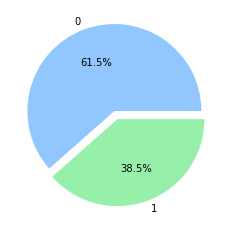

In [84]:
check_data_balance(y_train)

0    2074
1    1298
Name: TARGET, dtype: int64

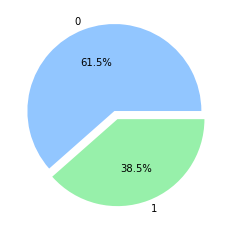

In [85]:
check_data_balance(y_test)

**Pre-proceesing the Pipeline**

In [38]:
pipeline_categorical = Pipeline([
  ('onehot', OneHotEncoder(handle_unknown="ignore")),
])

pipeline_numerical = Pipeline([
  ('scaler', MinMaxScaler(feature_range=(0,1))),
])

pipeline_full = ColumnTransformer([
  ("categorical", pipeline_categorical, columns_categorical),
  ("numerical", pipeline_numerical, columns_numerical),
])

**Testing**

In [39]:
# testing
# pipeline_numerical.fit_transform(X_train[columns_numerical]).shape
pipeline_categorical.fit_transform(X_train[columns_categorical]).toarray().shape
# pipeline_full.fit_transform(X_train).toarray().shape

(13488, 5185)

**Apply the Pipeline**

In [40]:
pipeline_full.fit(X_train)
X_train_transformed = pipeline_full.transform(X_train)
X_test_transformed = pipeline_full.transform(X_test)

**Train an ML model on the transformed training set**

*Random Forest*

In [89]:
from sklearn.ensemble  import RandomForestClassifier
from time import time

In [90]:
classifier_r = RandomForestClassifier()

start = time()
classifier_r.fit(X_train_transformed, y_train)
end = time()
train_time_r100 = end - start
print(f'That took {train_time_r100} seconds') 

That took 10.90365219116211 seconds


In [91]:
y_pred_r = classifier_r.predict(X_test_transformed)
y_pred_proba_r = classifier_r.predict_proba(X_test_transformed)

roc= roc_auc_score(y_test, y_pred_proba_r[:,1])
acc = accuracy_score(y_test, y_pred_r)
prec = precision_score(y_test, y_pred_r)
rec = recall_score(y_test, y_pred_r)
f1 = f1_score(y_test, y_pred_r)

results = pd.DataFrame([['Random_forest ', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])

results

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Random_forest,0.845196,0.865348,0.708012,0.778814,0.923369


Random forest, like its name implies, consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction. In other words, it fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

The classifier is using only the default parameters, available in sklearn.

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html 

Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.

Recall (Sensitivity) is the ratio of correctly predicted positive observations to the all observations in actual class.

F1 Score is the weighted average of Precision and Recall, which is better than accuracy because we have a relatively unbalanced data set.

AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.

It seems that Random forest is performing quite well, in terms of ROC curve, which is a more useful predictor for an unbalanced dataset.

*Hyper-parameter tuning with Randomized Search CV (Random Forest*

In [92]:
list(np.linspace(10, 120, 10, dtype = int))

[10, 22, 34, 46, 58, 71, 83, 95, 107, 120]

In [93]:
list(np.linspace(10, 300, 10, dtype = int))

[10, 42, 74, 106, 138, 171, 203, 235, 267, 300]

In [94]:
param_dist = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 120, 10, dtype = int)),
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 6, 8, 12],
               'min_samples_split': [5, 7, 10],
               'n_estimators': list(np.linspace(10, 300, 10, dtype = int))}

# run randomized search
n_iter_search = 10
random_search = RandomizedSearchCV(classifier_r, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, verbose= 1,n_jobs = -1)


random_search.fit(X_train_transformed,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.2min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 22, 34, 46, 58, 71,
                                                      83, 95, 107, 120],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [4, 6, 8, 12],
                                        'min_samples_split': [5, 7, 10],
                                        'n_estimators': [10, 42, 74, 106, 138,
                                                         171, 203, 235, 267,
                                                         300]},
                   verbose=1)

In [95]:
random_search.best_params_

{'n_estimators': 138,
 'min_samples_split': 7,
 'min_samples_leaf': 4,
 'max_features': None,
 'max_depth': 95,
 'criterion': 'gini'}

In [96]:
random_search.best_estimator_

RandomForestClassifier(max_depth=95, max_features=None, min_samples_leaf=4,
                       min_samples_split=7, n_estimators=138)

In [97]:
rf_clf = random_search.best_estimator_
rf_clf.fit(X_train_transformed, y_train)

y_pred_r_tuned = rf_clf.predict(X_test_transformed)
y_pred_proba_r_tuned = rf_clf.predict_proba(X_test_transformed)

roc= roc_auc_score(y_test, y_pred_proba_r_tuned[:,1])
acc = accuracy_score(y_test, y_pred_r_tuned)
prec = precision_score(y_test, y_pred_r_tuned )
rec = recall_score(y_test, y_pred_r_tuned)
f1 = f1_score(y_test, y_pred_r_tuned)

result_tuned = pd.DataFrame([['Random Forest Tuned', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])

result_tuned

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Random Forest Tuned,0.861507,0.834272,0.798921,0.816214,0.944823


RandomizedSearchCV implements a “fit” method and a “predict” method like any classifier except that the parameters of the classifier used to predict is optimized by cross-validation.

In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.


In [96]:
def feature_importance(estimator):
    for f, imp in zip(columns_predictors, estimator.feature_importances_):
        print(f, "{:2f}".format(imp))

In [97]:
feature_importance(rf_clf)

YEAR 0.000000
TIME 0.000000
HOUR 0.000000
STREET1 0.000000
STREET2 0.000000
OFFSET 0.000000
ROAD_CLASS 0.000000
DISTRICT 0.000000
WARDNUM 0.000000
DIVISION 0.000000
LOCCOORD 0.000000
ACCLOC 0.000000
TRAFFCTL 0.000000
VISIBILITY 0.000000
LIGHT 0.000000
RDSFCOND 0.000000
IMPACTYPE 0.000000
INVTYPE 0.000000
INVAGE 0.000000
INITDIR 0.000028
VEHTYPE 0.000000
MANOEUVER 0.000000
DRIVACT 0.000000
DRIVCOND 0.000000
PEDTYPE 0.000000
PEDACT 0.000000
PEDCOND 0.000000
CYCLISTYPE 0.000000
CYCACT 0.000000
CYCCOND 0.000000
PEDESTRIAN 0.000014
CYCLIST 0.000000
AUTOMOBILE 0.000000
MOTORCYCLE 0.000000
TRUCK 0.000000
TRSN_CITY_VEH 0.000000
EMERG_VEH 0.000000
PASSENGER 0.000000
SPEEDING 0.000000
AG_DRIV 0.000000
REDLIGHT 0.000000
ALCOHOL 0.000000
DISABILITY 0.000000
POLICE_DIVISION 0.000000
HOOD_ID 0.000000
NEIGHBOURHOOD 0.000000
Season 0.000000
Month 0.000000
TimeOfDay 0.000000


Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree. It doesn't look like too many of the variables are important here.

**ROC Curve**

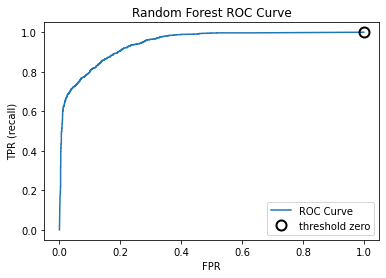

In [98]:
y_scores = rf_clf.predict_proba(X_test_transformed)

fpr, tpr, thresholds = roc_curve(y_test, y_scores[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title("Random Forest ROC Curve")

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

The ROC Curve is used to show the positive rate (FPR) against the true positive rate (TPR). For an ROC curve, the ideal curve for a classifier is to be close to the top left: you want a classifier that produces a high recall (true positive rate) while keeping a low false positive rate. We need to be careful of overfitting though. An overfit model will have essentially rote-learned the dataset and will show a great-looking ROC curve for training data but not for test data.

The point closest to the top left might be a better operating point than the one chosen by default. By allowing some True Positives to be missed, we will reduce the number of False Positives a lot. Again, be aware that choosing a threshold should not be done on the test set, but on a separate validation set.


By examining the graph here, we can see that the classfier is doing well, as long as we're cautious not to overfit the model. It is able to achieve high recall compared to the default threshold of 0 recall errors.

**Precision-Recall Curve**

Text(0, 0.5, 'Recall')

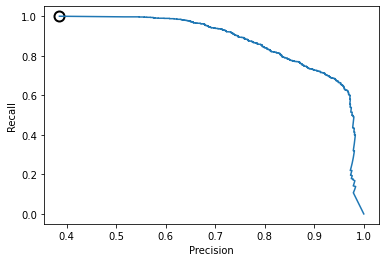

In [99]:
from sklearn.metrics import precision_recall_curve

#Random Forest Model

y_scores = rf_clf.predict_proba(X_test_transformed)

precision, recall, thresholds = precision_recall_curve(
y_test, y_scores[:, 1])

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")


The precision-recall curve shows the tradeoff between precision and recall for different thresholds. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

The closer a curve stays to the upper-right corner, the better the classifier. A point at the upper right means high precision and high recall for the same threshold. The curve starts at the top-left corner, corresponding to a very low threshold, classifying everything as the positive class. Raising the threshold moves the curve toward higher precision, but also lower recall. Raising the threshold more and more, we get to a situation where most of the points classified as being positive are true positives, leading to a very high precision but lower recall. The more the model keeps recall high as precision goes up, the better.

In general, the curves appears to be relatively flat and becomes more steep, as precision increases. It seems that for this graph, random forest starts to get steeper around 0.65.

**Confusion Matrix**

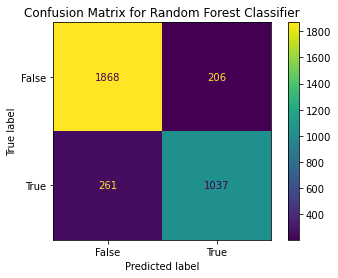

In [100]:
y_hat_dtc = rf_clf.predict(X_test_transformed)

confusion_matrix = metrics.confusion_matrix(y_test, y_hat_dtc)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

A confusion matrix is a technique for summarizing the performance of a classification algorithm. A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. It gives you insight not only into the errors being made by your classifier but more importantly the types of errors that are being made. It is this breakdown that overcomes the limitation of using classification accuracy alone.

These numbers are then organized into a table, or a matrix as follows:

The X axis represents predicted classes, the Y axis represents true classes.

The counts of correct and incorrect classification are then filled into the table.

The total number of correct predictions show up along the diagonal. The off-diagonal entries show how often that particular misclassification occurs. There appears to be 1037 true positives, 1868 true negatives, 261 false positives and 206 false negatives. 



**Decision tree**

In [101]:
classifier = DecisionTreeClassifier()

start = time()
classifier.fit(X_train_transformed, y_train)
end = time()
train_time_dt = end-start
print(f'This took {train_time_dt} seconds to complete')

This took 1.3336961269378662 seconds to complete


Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. Decision trees are simple to understand and to interpret, requires little data preparation, able to handle both numerical and categorical data. However, Decision-tree learners can create over-complex trees that do not generalize the data well. This is called overfitting. Decision tree learners can create biased trees if some classes dominate.

In [102]:
y_pred = classifier.predict(X_test_transformed)
y_pred_proba = classifier.predict_proba(X_test_transformed)

roc= roc_auc_score(y_test, y_pred_proba[:,1])
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

results_dt = pd.DataFrame([['Decision Tree', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])

results = pd.concat([results, results_dt])
results

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Random_forest,0.845196,0.865348,0.708012,0.778814,0.923369
0,Decision Tree,0.835409,0.789556,0.780431,0.784967,0.827263


It looks like Random Forest with default paramters is outperforming the default paramters decision trees. This outcome is not surprising because Random Forest is the output of multiple (randomly created) Decision Trees.

*Cross-Validate*

In [103]:
dtc = DecisionTreeClassifier()
scores = cross_val_score(dtc, X_train_transformed, y_train, cv = 5, scoring="roc_auc")
print(f'Scores: {scores}')
print(f'Mean:{"{:2f}".format(scores.mean())}')
print("Standard deviation: %0.2f" % (round(scores.std(),4)))

Scores: [0.82475741 0.82192585 0.8341438  0.82217913 0.83723858]
Mean:0.828049
Standard deviation: 0.01


*Hyper-Paramter Tuning with Grid Search (Decision Trees)*

In [104]:
parameters = {'criterion': ['gini','entropy'], 
              'splitter':['best','random'], 
              'max_depth':range(5, 20, 3),
              #'max_features':['auto','sqrt'], - these did not improve the metrics so i removed them
              #'min_samples_split':range(1,20),
              'min_samples_leaf': range(10, 30)
               }
clf_GS = GridSearchCV(DecisionTreeClassifier(), 
                      param_grid = parameters, 
                      cv = 5, 
                      verbose = 1, 
                      n_jobs = -1)
clf_GS.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 700 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.1min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 20, 3),
                         'min_samples_leaf': range(10, 30),
                         'splitter': ['best', 'random']},
             verbose=1)

In [105]:
clf_GS.best_params_

{'criterion': 'gini',
 'max_depth': 14,
 'min_samples_leaf': 13,
 'splitter': 'random'}

In [106]:
tree_clf_gs = clf_GS.best_estimator_
tree_clf_gs.fit(X_train_transformed, y_train)
y_pred_tree_tuned = tree_clf_gs.predict(X_test_transformed)
y_pred_proba_tree_tuned = tree_clf_gs.predict_proba(X_test_transformed) #to calculate ROC_AUC, we need model.predict_proba() instead of model.pred()

print(f"accuracy_score: {accuracy_score(y_test, y_pred_tree_tuned)}")
print(f"precision_score: {precision_score(y_test, y_pred_tree_tuned)}")
print(f"recall_score: {recall_score(y_test, y_pred_tree_tuned)}")
print(f"f1_score: {f1_score(y_test, y_pred_tree_tuned)}")
print(f"roc_auc_score: {roc_auc_score(y_test, y_pred_proba_tree_tuned[:,1])}")

accuracy_score: 0.8665480427046264
precision_score: 0.8897058823529411
recall_score: 0.7457627118644068
f1_score: 0.8113998323554065
roc_auc_score: 0.9363968452318157


*Hyper-parameter tuning with Randomized Search CV (Decision-Tree)*

In [107]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
param_dist = {'criterion': ['gini','entropy'], 
              'splitter':['best','random'], 
              'max_depth':range(1,20),
              'max_features':['auto','sqrt'],
              'min_samples_split':range(2,10),
              'min_samples_leaf':range(2,20)}

# run randomized search
n_iter_search = 5
random_search = RandomizedSearchCV(classifier, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=10, verbose= 1,n_jobs = -1)


random_search.fit(X_train_transformed,y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished


RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(1, 20),
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': range(2, 20),
                                        'min_samples_split': range(2, 10),
                                        'splitter': ['best', 'random']},
                   verbose=1)

In [108]:
random_search.best_params_

{'splitter': 'random',
 'min_samples_split': 4,
 'min_samples_leaf': 7,
 'max_features': 'sqrt',
 'max_depth': 16,
 'criterion': 'entropy'}

In [109]:
dt_clf = random_search.best_estimator_
dt_clf.fit(X_train_transformed, y_train)

y_pred_dt_tuned = dt_clf.predict(X_test_transformed)
y_pred_proba_dt_tuned = dt_clf.predict_proba(X_test_transformed)

roc= roc_auc_score(y_test, y_pred_proba_dt_tuned[:,1])
acc = accuracy_score(y_test, y_pred_dt_tuned)
prec = precision_score(y_test, y_pred_dt_tuned )
rec = recall_score(y_test, y_pred_dt_tuned)
f1 = f1_score(y_test, y_pred_dt_tuned)

model  = pd.DataFrame([['Decision Tree Tuned', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])

model

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Decision Tree Tuned,0.775504,0.881523,0.48151,0.62282,0.801286


It looks Grid Search did a better job of hyper-paramter tuning. We will use that instead.

In [110]:
tree_clf_gs = clf_GS.best_estimator_
tree_clf_gs.fit(X_train_transformed, y_train)
y_pred_tree_tuned = tree_clf_gs.predict(X_test_transformed)
y_pred_proba_tree_tuned = tree_clf_gs.predict_proba(X_test_transformed)

roc = roc_auc_score(y_test, y_pred_proba_tree_tuned[:,1])
acc = accuracy_score(y_test, y_pred_tree_tuned)
prec = precision_score(y_test, y_pred_tree_tuned)
rec = recall_score(y_test, y_pred_tree_tuned)
f1 = f1_score(y_test, y_pred_tree_tuned)

model = pd.DataFrame([['Decision Tree Tuned', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])

result_tuned = pd.concat([result_tuned, model])
result_tuned

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Random Forest Tuned,0.861507,0.834272,0.798921,0.816214,0.944823
0,Decision Tree Tuned,0.865955,0.890943,0.742681,0.810084,0.935376


Random forest and decision trees have a very similar output, but Random forest is doing slighly better in terms of roc auc score and F1 score.

*Tree Visualization*

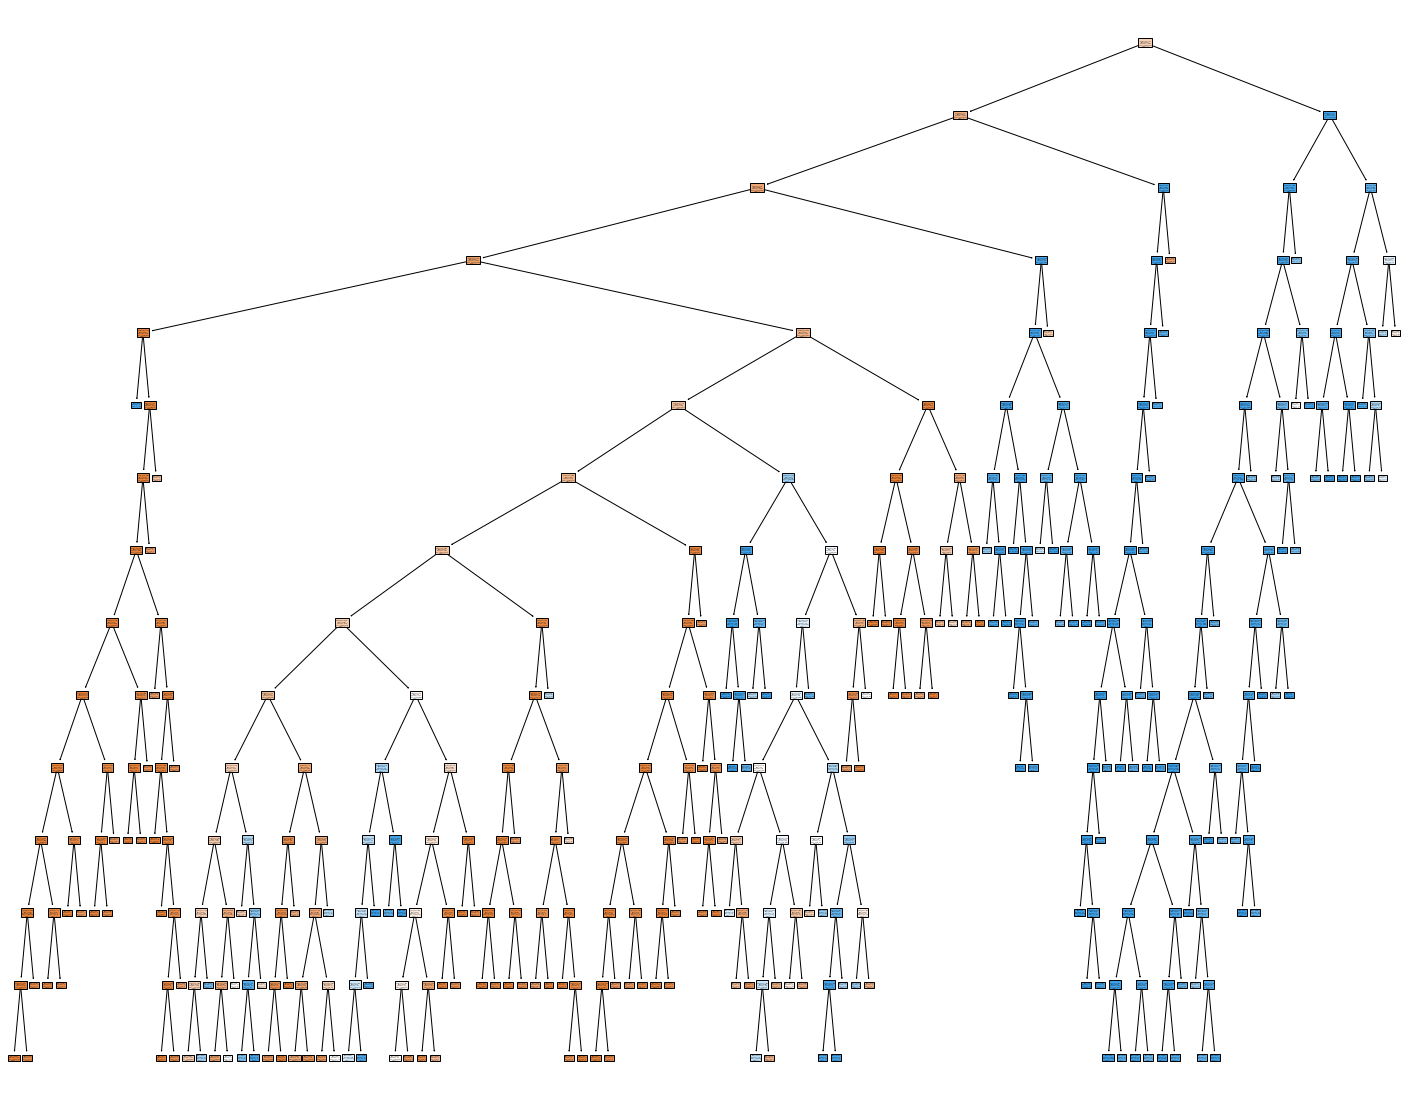

In [111]:
# Visualize the tree to understand how features are handled
from sklearn import tree
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree_clf_gs, 
                   # feature_names=X.columns,  
                   class_names='TARGET',
                   filled=True)

ROC Curve

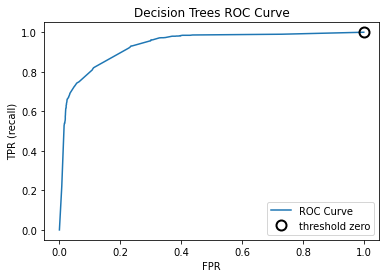

In [111]:
y_scores = tree_clf_gs.predict_proba(X_test_transformed)

fpr, tpr, thresholds = roc_curve(y_test, y_scores[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

plt.title("Decision Trees ROC Curve")

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

The ROC curve looks similar to the previous ROC curve, but its performing slightly worse.

*Precision-Recall Curve*

Text(0, 0.5, 'Recall')

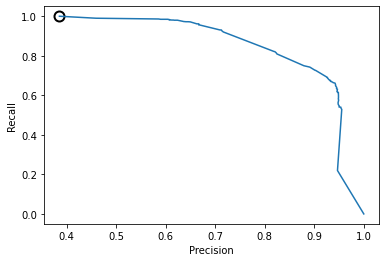

In [112]:
from sklearn.metrics import precision_recall_curve

#Random Forest Model

y_scores = tree_clf_gs.predict_proba(X_test_transformed)

precision, recall, thresholds = precision_recall_curve(
y_test, y_scores[:, 1])

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")


It looks similar to the Rnadom Forest precision-recall except it appears to be more steep as precision increases.

*Confusion Matrix*

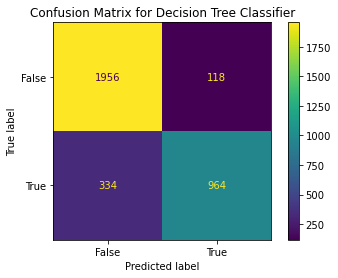

In [113]:
y_hat_dtc = tree_clf_gs.predict(X_test_transformed)

confusion_matrix = metrics.confusion_matrix(y_test, y_hat_dtc)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.title("Confusion Matrix for Decision Tree Classifier")
plt.show()


It looks like there was 964 true positives, 1956 true negatives. Approximately 334 false positives and 118 false negatives.

**Adaboost**

In [114]:
adaboost =AdaBoostClassifier()

start = time()
adaboost.fit(X_train_transformed, y_train)
end = time()
train_time_ada = end - start
print(f'This took {train_time_ada} seconds to complete')

This took 0.9832909107208252 seconds to complete


AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

In [115]:
y_pred = adaboost.predict(X_test_transformed)
y_pred_proba = adaboost.predict_proba(X_test_transformed)

from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
roc= roc_auc_score(y_test, y_pred_proba[:,1])
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

results_ada = pd.DataFrame([['Adaboost', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])

results = pd.concat([results, results_ada])
results

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Random_forest,0.845196,0.865348,0.708012,0.778814,0.923369
0,Decision Tree,0.835409,0.789556,0.780431,0.784967,0.827263
0,Adaboost,0.869217,0.884305,0.759630,0.817240,0.943304


Adaboost so far is outperforming decision trees with the default parameters.

*Hyper-parameter tuning with Randomized Search CV (Adaboost Classifier)*

In [116]:
param_dist = {'n_estimators':list(range(2, 200, 10)),
              'learning_rate':[0.1, 0.01, 0.001, 0.0001, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(adaboost, 
                                   param_distributions = param_dist,
                                   n_iter = n_iter_search, 
                                   cv = 5)

random_search.fit(X_train_transformed,y_train)

RandomizedSearchCV(cv=5, estimator=AdaBoostClassifier(), n_iter=20,
                   param_distributions={'learning_rate': [0.1, 0.01, 0.001,
                                                          0.0001, 0.2, 0.3, 0.4,
                                                          0.5, 0.6, 0.7, 0.8,
                                                          0.9, 1],
                                        'n_estimators': [2, 12, 22, 32, 42, 52,
                                                         62, 72, 82, 92, 102,
                                                         112, 122, 132, 142,
                                                         152, 162, 172, 182,
                                                         192]})

In [117]:
random_search.best_params_

{'n_estimators': 172, 'learning_rate': 0.6}

In [118]:
adaboost_tuned = random_search.best_estimator_
adaboost_tuned.fit(X_train_transformed, y_train)
y_pred_ada = adaboost_tuned.predict(X_test_transformed)
y_pred_proba_ada = adaboost_tuned.predict_proba(X_test_transformed)
roc= roc_auc_score(y_test, y_pred_proba_ada[:,1])
acc = accuracy_score(y_test, y_pred_ada)
prec = precision_score(y_test, y_pred_ada)
rec = recall_score(y_test, y_pred_ada)
f1 = f1_score(y_test, y_pred_ada)

model_ada = pd.DataFrame([['Adaboost Tuned', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])

result_tuned = pd.concat([result_tuned, model_ada])
result_tuned

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Random Forest Tuned,0.861507,0.834272,0.798921,0.816214,0.944823
0,Decision Tree Tuned,0.865955,0.890943,0.742681,0.810084,0.935376
0,Adaboost Tuned,0.868031,0.870547,0.771957,0.818293,0.941815


With the tuned parameters Adaboost did better than Decision trees and random forest in terms of accuracy and F1 score. In terms of roc auc score, it did better than decision trees, worse than random forest.

ROC Curve

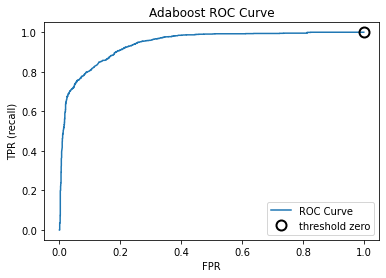

In [119]:
y_scores = adaboost_tuned.predict_proba(X_test_transformed)

fpr, tpr, thresholds = roc_curve(y_test, y_scores[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title("Adaboost ROC Curve")

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

The adaboost ROC curve looks better than decision trees, but slighly worse than random forest.

*Precision-Recall Curve*

Text(0, 0.5, 'Recall')

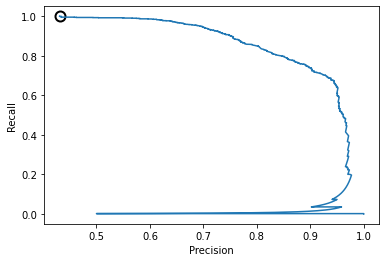

In [120]:
from sklearn.metrics import precision_recall_curve

#Random Forest Model

y_scores = adaboost_tuned.predict_proba(X_test_transformed)

precision, recall, thresholds = precision_recall_curve(
y_test, y_scores[:, 1])

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")


The Adaboost precision-recall curve appears to be doing better than the previous two curves, which is evident by the F1 score.

*Confusion Matrix*

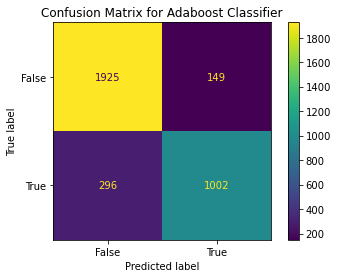

In [161]:
y_hat_dtc = adaboost_tuned.predict(X_test_transformed)

confusion_matrix = metrics.confusion_matrix(y_test, y_hat_dtc)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.title("Confusion Matrix for Adaboost Classifier")
plt.show()

It looks like adaboost had 1002 true positives, 1925 true negatives. Approximately 296 false positives and 149 false negatives.

*Learning Curve*

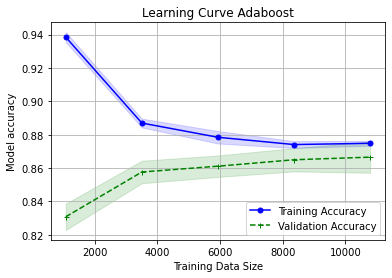

In [122]:
# Use learning curve to get training and test scores along with train sizes
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(adaboost_tuned, X_train_transformed,y_train, cv=5, return_times=True)

# Calculate training and test mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve Adaboost')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

Learning curve in machine learning is used to assess how models will perform with varying numbers of training samples. This is achieved by monitoring the training and validation scores (model accuracy) with an increasing number of training samples. Models that have underfitting / high-bias, both the training and validation scores are very low and also lesser than the desired accuracy. Models that have overfitting / high-variance, there is a large gap between training and validation accuracy. Also, training accuracy may come to be more than desired accuracy.

For this particular graph, some notable elements are:

For training sample size less than 3800, the difference between training and validation accuracy is much larger. This is the case of overfitting.
For training size greater than 3800, the model is better. It is a sign of good bias-variance trade-off. Past 8200, it seems to start widening a bit.

**Extra Tree Classifier**

In [123]:
Xtree = ExtraTreesClassifier()

start = time()
Xtree.fit(X_train_transformed, y_train)
end = time()
train_time_xtree = end - start
print(f'This took {train_time_xtree} to complete')

This took 17.297630786895752 to complete


In [124]:
y_pred_xtree = Xtree.predict(X_test_transformed)
y_pred_proba_xtree = Xtree.predict_proba(X_test_transformed)

from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
roc= roc_auc_score(y_test, y_pred_proba_xtree[:,1])
acc = accuracy_score(y_test, y_pred_xtree)
prec = precision_score(y_test, y_pred_xtree)
rec = recall_score(y_test, y_pred_xtree)
f1 = f1_score(y_test, y_pred_xtree)

results_xt = pd.DataFrame([['Extra Trees', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])

results = pd.concat([results, results_xt])
results

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Random_forest,0.845196,0.865348,0.708012,0.778814,0.923369
0,Decision Tree,0.835409,0.789556,0.780431,0.784967,0.827263
0,Adaboost,0.869217,0.884305,0.759630,0.817240,0.943304
0,Extra Trees,0.846085,0.851217,0.727273,0.784379,0.907211


Extra Tree classifier is a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

Extra trees with default paramteres seems to be doing better than decision trees in terms of ROC. It also seems to be doing better than random forest in accuracy score and F1 score.

**Hyper-parameter tuning with Randomized Search CV (Extra Trees Classifier)**

In [125]:
param_dist ={'criterion': ['gini','entropy'],
              'max_depth':[2,4,5,6,7,8,9,10,12],
              'max_features':['auto','sqrt'],
              'min_samples_leaf':[150]} 


# run randomized search
n_iter_search =10
random_search = RandomizedSearchCV(Xtree, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, verbose= 1,n_jobs = -1)

random_search.fit(X_train_transformed,y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.2s finished


RandomizedSearchCV(cv=5, estimator=ExtraTreesClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 4, 5, 6, 7, 8, 9, 10,
                                                      12],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [150]},
                   verbose=1)

In [126]:
random_search.best_params_

{'min_samples_leaf': 150,
 'max_features': 'auto',
 'max_depth': 10,
 'criterion': 'gini'}

In [127]:
Xtree_clf = random_search.best_estimator_
Xtree_clf.fit(X_train_transformed, y_train)

y_pred_xtree = Xtree_clf.predict(X_test_transformed)
y_pred_proba_xtree = Xtree_clf.predict_proba(X_test_transformed)

roc= roc_auc_score(y_test, y_pred_proba_xtree[:,1])
acc = accuracy_score(y_test, y_pred_xtree)
prec = precision_score(y_test, y_pred_xtree)
rec = recall_score(y_test, y_pred_xtree)
f1 = f1_score(y_test, y_pred_xtree)

model_xt =  pd.DataFrame([['X Tree Tuned', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])

result_tuned = pd.concat([result_tuned, model_xt])
result_tuned

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Random Forest Tuned,0.861507,0.834272,0.798921,0.816214,0.944823
0,Decision Tree Tuned,0.865955,0.890943,0.742681,0.810084,0.935376
0,Adaboost Tuned,0.868031,0.870547,0.771957,0.818293,0.941815
0,X Tree Tuned,0.797153,0.946221,0.501541,0.655589,0.896943


Extra trees do not trees appear to be performing well, relative to the other classifiers.

*ROC Curve*

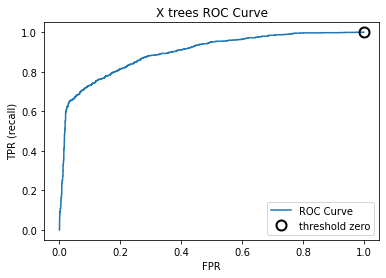

In [128]:
y_scores = Xtree_clf.predict_proba(X_test_transformed)

fpr, tpr, thresholds = roc_curve(y_test, y_scores[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title("X trees ROC Curve")

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

The plot confirms our finding that the X trees seems to be performing worse, in terms of ROC curve.

*Precision-Recall Curve*

Text(0, 0.5, 'Recall')

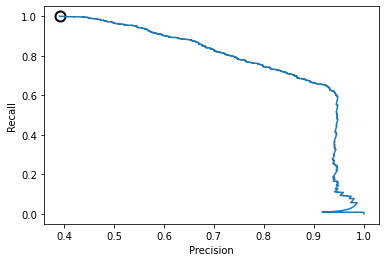

In [129]:
from sklearn.metrics import precision_recall_curve

#Random Forest Model

y_scores = Xtree_clf.predict_proba(X_test_transformed)

precision, recall, thresholds = precision_recall_curve(
y_test, y_scores[:, 1])

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")


Extra trees seems to be performing worse than the rest of the models, which is evident by the lower F1 score.

*Confusion Matrix*

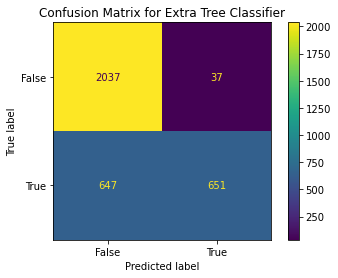

In [130]:
y_hat_dtc = Xtree_clf.predict(X_test_transformed)

confusion_matrix = metrics.confusion_matrix(y_test, y_hat_dtc)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.title("Confusion Matrix for Extra Tree Classifier")
plt.show()

It looks like Extra Trees had 651 true positives, 2037 true negatives. Approximately 647 false positives and 37 false negatives.

**Gradient Boosting**

In [131]:
gboost = GradientBoostingClassifier()
start = time()
gboost.fit(X_train_transformed, y_train)
end = time()
train_time_g = end - start
print(f'This took {train_time_g} seconds to complete')

This took 3.635787010192871 seconds to complete


In [132]:
y_pred_gboost = gboost.predict(X_test_transformed)
y_pred_proba_gboost = gboost.predict_proba(X_test_transformed)

from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
roc=roc_auc_score(y_test, y_pred_proba_gboost[:,1])
acc = accuracy_score(y_test, y_pred_gboost)
prec = precision_score(y_test, y_pred_gboost)
rec = recall_score(y_test, y_pred_gboost)
f1 = f1_score(y_test, y_pred_gboost)

results_gb = pd.DataFrame([['Gboost', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])

results = pd.concat([results, results_gb])
results

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Random_forest,0.845196,0.865348,0.708012,0.778814,0.923369
0,Decision Tree,0.835409,0.789556,0.780431,0.784967,0.827263
0,Adaboost,0.869217,0.884305,0.759630,0.817240,0.943304
0,Extra Trees,0.846085,0.851217,0.727273,0.784379,0.907211
0,Gboost,0.865955,0.927273,0.707242,0.802448,0.946462


Gradient boosting classifiers are a group of machine learning algorithms that combine many weak learning models together to create a strong predictive model. Decision trees are usually used when doing gradient boosting.

Gradient booster seems to be performing well in terms of accuracy and ROC curve.

Hyper-parameter tuning with Randomized Search CV (Gradient Boost Classifier)

In [133]:
param_dist = {'n_estimators': [50,100,150,200], 
              'random_state':[47],
              'max_depth': [3,5,7,10]} 

# run randomized search
n_iter_search = 10
random_search = RandomizedSearchCV(gboost, 
                                   param_distributions = param_dist,
                                   n_iter = n_iter_search, 
                                   cv = 5, 
                                   verbose = 1,
                                   n_jobs = -1)

random_search.fit(X_train_transformed,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.6min finished


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [50, 100, 150, 200],
                                        'random_state': [47]},
                   verbose=1)

In [134]:
random_search.best_params_

{'random_state': 47, 'n_estimators': 100, 'max_depth': 5}

In [135]:
gboost_clf = random_search.best_estimator_
gboost_clf.fit(X_train_transformed, y_train)

y_pred_gb = gboost_clf.predict(X_test_transformed)
y_pred_proba_gb = gboost_clf.predict_proba(X_test_transformed)

roc= roc_auc_score(y_test, y_pred_proba_gb[:,1])
acc = accuracy_score(y_test, y_pred_gb)
prec = precision_score(y_test, y_pred_gb)
rec = recall_score(y_test, y_pred_gb)
f1 = f1_score(y_test, y_pred_gb)

model_gb =  pd.DataFrame([['GBoost Tuned', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])

result_tuned = pd.concat([result_tuned, model_gb])
result_tuned

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Random Forest Tuned,0.861507,0.834272,0.798921,0.816214,0.944823
0,Decision Tree Tuned,0.865955,0.890943,0.742681,0.810084,0.935376
0,Adaboost Tuned,0.868031,0.870547,0.771957,0.818293,0.941815
0,X Tree Tuned,0.797153,0.946221,0.501541,0.655589,0.896943
0,GBoost Tuned,0.879300,0.911357,0.760401,0.829063,0.949291


Gradient booster seems to be outperforming the other models in terms of accuracy and ROC curve.

*ROC Curve*

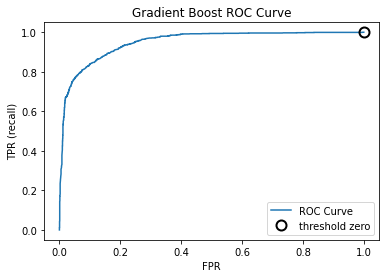

In [136]:
y_scores = gboost_clf.predict_proba(X_test_transformed)

fpr, tpr, thresholds = roc_curve(y_test, y_scores[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title("Gradient Boost ROC Curve")

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

The best performing ROC curve so far.

*Precision-Recall Curve*

Text(0, 0.5, 'Recall')

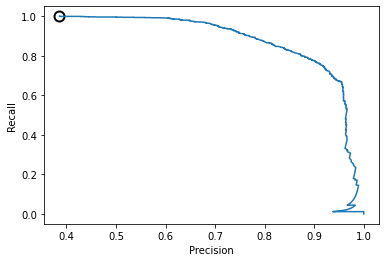

In [137]:
from sklearn.metrics import precision_recall_curve

#Random Forest Model

y_scores = gboost_clf.predict_proba(X_test_transformed)

precision, recall, thresholds = precision_recall_curve(
y_test, y_scores[:, 1])

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")


Gradient boost precision-recall curve seems to be performing well. It's relatively more flat than the other curves.

*Confusion Matrix*

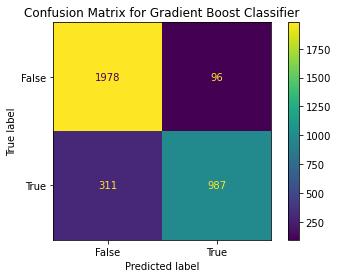

In [138]:
y_hat_dtc = gboost_clf.predict(X_test_transformed)

confusion_matrix = metrics.confusion_matrix(y_test, y_hat_dtc)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.title("Confusion Matrix for Gradient Boost Classifier")
plt.show()

It looks like Gradient Boost had 967 true positives, 1978 true negatives. Approximately 311 false positives and 96 false negatives.

*Learning Curve*

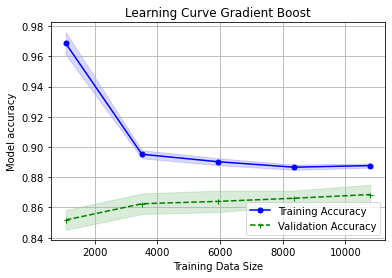

In [139]:
# Use learning curve to get training and test scores along with train sizes
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(gboost_clf, X_train_transformed,y_train, cv=5, return_times=True)

# Calculate training and test mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve Gradient Boost')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

For this particular graph, some notable elements are:

* For training sample size less than 3800, the difference between training and validation accuracy is much larger. This is the case of overfitting.
* For training size greater than 3800, the model is better, but it seems to wider apart relative to adaboost.
* You can also see that around 8200 it starts to diverge again for for Adaboost.


**Extra Gradient Booster**

In [140]:
xgb_classifier = XGBClassifier()
start = time()

xgb_classifier.fit(X_train_transformed, y_train)
end = time()
train_time_xgb = end - start
print(f'This took {train_time_xgb} seconds to complete')

This took 2.395509958267212 seconds to complete


In [141]:
y_pred = xgb_classifier.predict(X_test_transformed)
y_pred_proba = xgb_classifier.predict_proba(X_test_transformed)

roc= roc_auc_score(y_test, y_pred_proba[:,1])
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

results_xgb = pd.DataFrame([['XGboost', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])

results = pd.concat([results, results_xgb])
results

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Random_forest,0.845196,0.865348,0.708012,0.778814,0.923369
0,Decision Tree,0.835409,0.789556,0.780431,0.784967,0.827263
0,Adaboost,0.869217,0.884305,0.759630,0.817240,0.943304
0,Extra Trees,0.846085,0.851217,0.727273,0.784379,0.907211
0,Gboost,0.865955,0.927273,0.707242,0.802448,0.946462
0,XGboost,0.865955,0.850746,0.790447,0.819489,0.944778


Extreme Gradient Boosting (XGBoost) is an open-source library that provides an efficient and effective implementation of the gradient boosting algorithm. 

It seems to be relatively similar to Gradient Boost.

Hyper-parameter tuning with Randomized Search CV (Extra Gradient Boost Classifier)

In [142]:
param_dist ={'n_estimators': [50,100,150,200], 
             'max_depth': [3,5,7,10], 
             'min_child_weight': [2,3,4,5]} 

# run randomized search
n_iter_search =10
random_search = RandomizedSearchCV(xgb_classifier, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, verbose= 1,n_jobs = -1)


random_search.fit(X_train_transformed,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.5s finished


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=0, gpu_id=-1,
                                           grow_policy='depthwise',
                                           importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_bin=256,..._cat_to_onehot=4,
                                           max_delta_step=0, max_depth=6,
                                           max_

In [143]:
random_search.best_params_

{'n_estimators': 50, 'min_child_weight': 4, 'max_depth': 3}

In [144]:
Xgboost_clf = random_search.best_estimator_
Xgboost_clf.fit(X_train_transformed, y_train)

y_pred_xgb = Xgboost_clf.predict(X_test_transformed)
y_pred_proba_xgb = Xgboost_clf.predict_proba(X_test_transformed)

roc= roc_auc_score(y_test, y_pred_proba_xgb[:,1])
acc = accuracy_score(y_test, y_pred_xgb)
prec = precision_score(y_test, y_pred_xgb)
rec = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)

model_xgb =  pd.DataFrame([['XGBoost Tuned', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])

result_tuned = pd.concat([result_tuned, model_xgb])
result_tuned

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Random Forest Tuned,0.861507,0.834272,0.798921,0.816214,0.944823
0,Decision Tree Tuned,0.865955,0.890943,0.742681,0.810084,0.935376
0,Adaboost Tuned,0.868031,0.870547,0.771957,0.818293,0.941815
0,X Tree Tuned,0.797153,0.946221,0.501541,0.655589,0.896943
0,GBoost Tuned,0.879300,0.911357,0.760401,0.829063,0.949291
0,XGBoost Tuned,0.868921,0.888385,0.754237,0.815833,0.947483


It looks like Gradient Boosting Classifier and XGBoost seem to be outperforming the other models, in terms of ROC curve, accuracy score, and F1 score. Gradient Boosting classifier outperformed XGBoost in terms of roc auc curve This is not surprising because Gradient Boosting Classifier often provides predictive scores that are far better than other algorithms, and it works well with missing values. There are some disadvantages, however, which is that this method is sensitive to outliers. Outliers will have much larger residuals than non-outliers, so gradient boosting will focus a disproportionate amount of its attention on those points. Using Mean Absolute Error (MAE) to calculate the error instead of Mean Square Error (MSE) can help reduce the effect of these outliers since the latter gives more weight to larger differences. The parameter ‘criterion’ helps you choose this function. It can also be prone to overfitting if the number of trees is too large. The parameter ‘n_estimators’ can help determine a good point to stop before our model starts overfitting. Finally, computation can take a long time. In the chart below, we did find that it took a bit longer than some of the other models, however, it was still shorter than Random Forest and decision trees. The hyper-parameter tuned Extra Tree Classifier performed the worst in terms of accuracy score, F1 score, and ROC curve. This may be because it does not perform bootstrap aggregation like in the random forest. In simple words, takes a random subset of data without replacement. Thus nodes are split on random splits and not on best split. 



**ROC Curve**

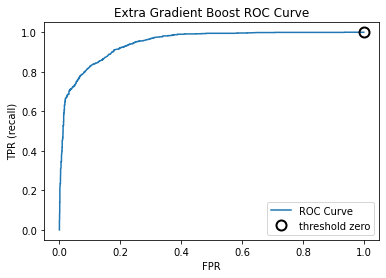

In [145]:
y_scores = Xgboost_clf.predict_proba(X_test_transformed)

fpr, tpr, thresholds = roc_curve(y_test, y_scores[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title("Extra Gradient Boost ROC Curve")

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

The Extra Gradient Boost is also doing well in terms of ROC curve, however, the regular Gradient Boost did a better job.

*Precision-Recall Curve*

Text(0, 0.5, 'Recall')

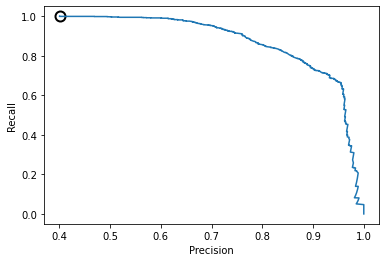

In [146]:
from sklearn.metrics import precision_recall_curve

#Random Forest Model

y_scores = Xgboost_clf.predict_proba(X_test_transformed)

precision, recall, thresholds = precision_recall_curve(
y_test, y_scores[:, 1])

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")


The XG Boost precision-recall curve is similar to the Gradient Boost recall curve, which is also evident by the relatively close F1 scores.

*Confluence Matrix*

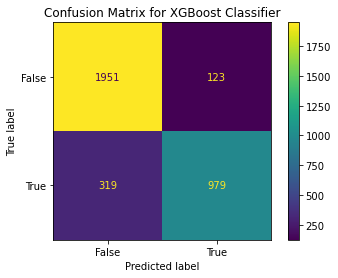

In [147]:
y_hat_dtc = Xgboost_clf.predict(X_test_transformed)

confusion_matrix = metrics.confusion_matrix(y_test, y_hat_dtc)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.title("Confusion Matrix for XGBoost Classifier")
plt.show()

It looks like Extra Gradient Boost had 979 true positives, 1951 true negatives. Approximately 319 false positives and 123 false negatives.

Extreme Gradient Booster did not the do better than Gradient Booster.

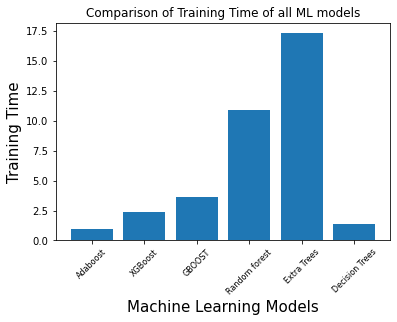

In [148]:
model = ['Adaboost','XGBoost', 'GBOOST', 'Random forest', 'Extra Trees', 'Decision Trees']
Train_Time = [
    train_time_ada,
    train_time_xgb,
    train_time_g,
    train_time_r100,
    train_time_xtree,
    train_time_dt,
]
index = np.arange(len(model))
plt.bar(index, Train_Time)
plt.xlabel('Machine Learning Models', fontsize=15)
plt.ylabel('Training Time', fontsize=15)
plt.xticks(index, model, fontsize=8, rotation = 45)
plt.title('Comparison of Training Time of all ML models')
plt.show()

It looks like Random Forest and Extra Trees took the longest time. Adaboost and decision trees took the shortest amount of time, but their performance was not the strongest out of the group.

*Accuracy Score*

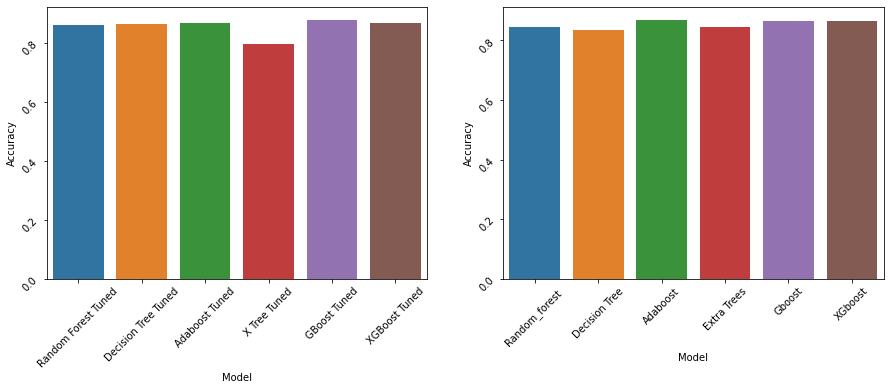

In [149]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
sns.barplot(ax = ax[0], data = result_tuned, x = 'Model', y = 'Accuracy')
ax[0].tick_params(labelrotation=45)
sns.barplot(ax = ax[1], data = results, x = 'Model', y = 'Accuracy')
ax[1].tick_params(labelrotation=45)

Accuracy is a metric that generally describes how the model performs across all classes. It is useful when all classes are of equal importance. It is calculated as the ratio between the number of correct predictions to the total number of predictions.

The accuracy score was pretty consistent among the models, except for Extra trees. Extra trees seemed to perform worse with the hyper-parameter tuning and and so did adaboost, in terms of accuracy.

*Precision Score*

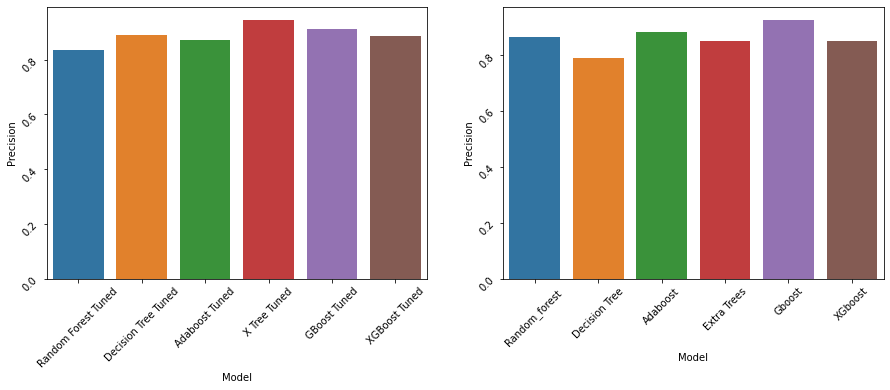

In [150]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
sns.barplot(ax = ax[0], data = result_tuned, x = 'Model', y = 'Precision')
ax[0].tick_params(labelrotation=45)
sns.barplot(ax = ax[1], data = results, x = 'Model', y = 'Precision')
ax[1].tick_params(labelrotation=45)

Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. 

It looks like X-tree had the highest precision ratio with hyper-parameter tuning, relative to the other models. It had one of the lowest with no hyper-paramter tuning. In other words, there was a significant improvement in precision after tuning.

*Recall Score*

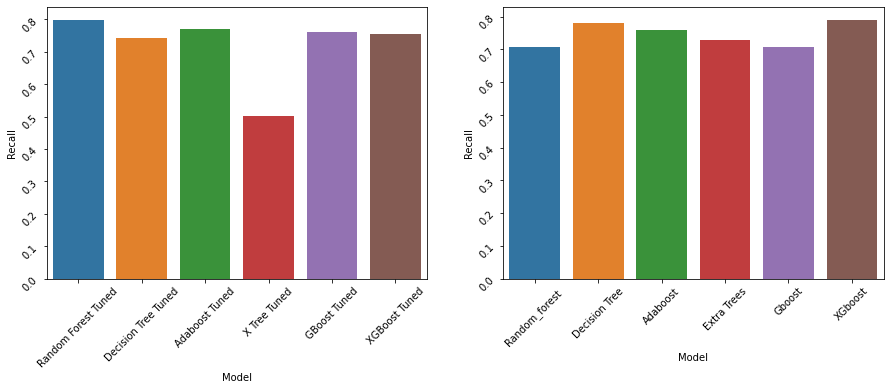

In [151]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
sns.barplot(ax = ax[0], data = result_tuned, x = 'Model', y = 'Recall')
ax[0].tick_params(labelrotation=45)
sns.barplot(ax = ax[1], data = results, x = 'Model', y = 'Recall')
ax[1].tick_params(labelrotation=45)

Recall (Sensitivity) is the ratio of correctly predicted positive observations to all observations in actual class.

While, X-tree tuned had the highest precision in the previous graph, it had the lowest recall, which shows the precision-recall trade off.

The precision-recall trade off essentially means that one cannot have both precision and recall high. If precision increases, recall will decrease, and vice versa. This is called the precision/recall tradeoff.

*F1 Score*

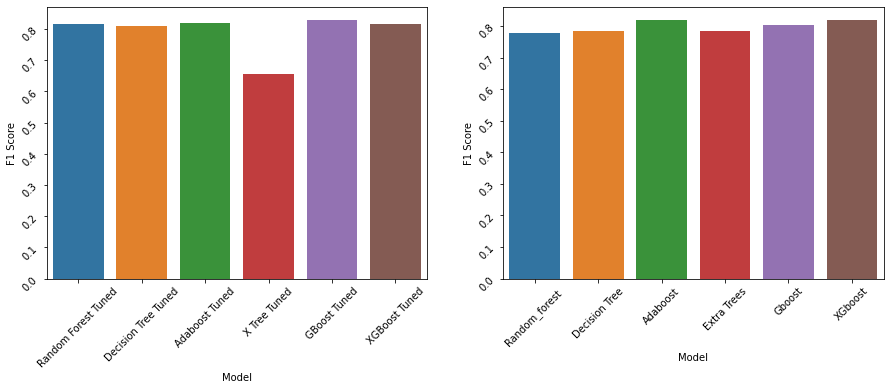

In [152]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
sns.barplot(ax = ax[0], data = result_tuned, x = 'Model', y = 'F1 Score')
ax[0].tick_params(labelrotation=45)
sns.barplot(ax = ax[1], data = results, x = 'Model', y = 'F1 Score')
ax[1].tick_params(labelrotation=45)

F1 Score is the weighted average of Precision and Recall, which is better than accuracy because we have a relatively unbalanced data set.

As a result of the low recall it appears that X tree tuned also has the lowest F1 score. Gradient Booster seems to have a slighly higher score than the rest.

*ROC Score*

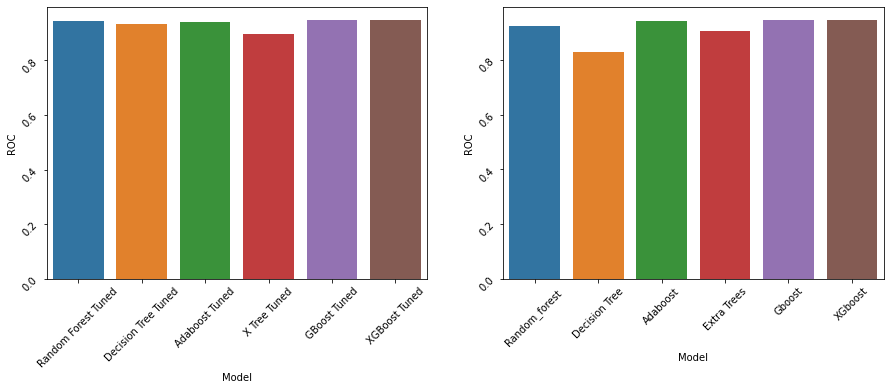

In [153]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
sns.barplot(ax = ax[0], data = result_tuned, x = 'Model', y = 'ROC')
ax[0].tick_params(labelrotation=45)
sns.barplot(ax = ax[1], data = results, x = 'Model', y = 'ROC')
ax[1].tick_params(labelrotation=45)

AUC - ROC curve is a performance measurement for the classification problems at various threshold settings.  ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.

The ROC curve with hyper paramter tuning is relatively similar to the other models. It appears that Decision trees had a significant improvement with hyper-parameter tuning.

**Appendix**

**Predicting Fatalities**

In [42]:
# defining the fatality only as a target variable
df = data.copy()
source = pd.read_csv('Motor Vehicle Collisions with KSI Data - 4326.csv', index_col=0)
df['INJURY'] = source['INJURY']
df.INJURY.fillna('Unknown', inplace = True)
df['TARGET_fatality'] = df['INJURY'].replace(['Fatal', 'Major','Minor','Minimal','None', 'Unknown'],[1,0,0,0,0,0])
df

C:\Users\novikova\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (42) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,YEAR,TIME,HOUR,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,WARDNUM,DIVISION,...,DISABILITY,POLICE_DIVISION,HOOD_ID,NEIGHBOURHOOD,TARGET,Season,Month,TimeOfDay,INJURY,TARGET_fatality
_id,,,,,,,,,,,,,,,,,,,,,
1,2006,852,8,BLOOR ST W,DUNDAS ST W,None,Major Arterial,Toronto and East York,4,11,...,No,D11,88,High Park North (88),0,Spring,3,Morning,None,0
2,2006,852,8,BLOOR ST W,DUNDAS ST W,None,Major Arterial,Toronto and East York,4,11,...,No,D11,88,High Park North (88),1,Spring,3,Morning,Fatal,1
3,2006,915,9,MORNINGSIDE AVE,SHEPPARD AVE E,None,Major Arterial,Scarborough,25,42,...,No,D42,131,Rouge (131),1,Spring,3,Morning,Fatal,1
4,2006,915,9,MORNINGSIDE AVE,SHEPPARD AVE E,None,Major Arterial,Scarborough,25,42,...,No,D42,131,Rouge (131),0,Spring,3,Morning,None,0
5,2006,240,2,EGLINTON AVE E,COMMONWEALTH AVE,None,Major Arterial,Scarborough,"21,20",41,...,No,D41,138,Eglinton East (138),0,Spring,3,Night,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16856,2020,1340,13,BRIMLEY RD,BARKDENE HILLS,50 m South of,Other,Rest of GTA,Unknown,Unknown,...,No,D41,123,Cliffcrest (123),1,Summer,8,Afternoon,Major,0
16857,2020,1205,12,EGLINTON AVE E,BELLAMY RD N,None,Major Arterial,Scarborough,"21,20",43,...,No,D43,138,Eglinton East (138),0,Fall,9,Afternoon,None,0
16858,2020,1205,12,EGLINTON AVE E,BELLAMY RD N,None,Major Arterial,Scarborough,"21,20",43,...,No,D43,138,Eglinton East (138),0,Fall,9,Afternoon,Minor,0


In [43]:
# use the pipeline as previously defined 
## even though this code is in an appendix and we are using cleaned up code from this project
## earlier on a separate pipeline was developed for the fatality prediction - which there is no need to 
## re-invent the wheel here
TARGET = "TARGET_fatality"
X = df[columns_predictors]
y = df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123, stratify=y)
pipeline_full.fit(X_train)
X_train_transformed = pipeline_full.transform(X_train)
X_test_transformed = pipeline_full.transform(X_test)

In [50]:
# training a naive random forest classifier
classifier_r = RandomForestClassifier()
classifier_r.fit(X_train_transformed, y_train)
y_pred_r = classifier_r.predict(X_test_transformed)
# y_pred_proba_r = classifier_r.predict_proba(X_test_transformed)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_r)
acc = metrics.accuracy_score(y_test, y_pred_r)
confusion_matrix

array([[3202,    6],
       [ 160,    4]], dtype=int64)

In [51]:
print("The accuracy for the optimized-parameter RandomForestClassifier is "+str(round(acc*100,2)))
print("Compared to the accuracy of the null hypothesis of "+str((1-sum(y_test)/len(y_test))*100)+"%")

The accuracy for the optimized-parameter RandomForestClassifier is 95.08
Compared to the accuracy of the null hypothesis of 95.13641755634639%


In [ ]:
# The accuracy of the naive RandomForestClassifier is below the accuracy of the null hypothesis
# And through the confusion matrix we see that very few test set items are being predicted in the target variable = 1
# Overall, this "test classifier" to explore the waters of the prediction problem, together with how unbalanced
# the dataset is for fatalities assured us that this is not the best data science problem to pursue within this dataset.

In [54]:
# perhaps looking at only one group will be better
summary_invtype = []
summary_invtype = df.groupby('INVTYPE')['TARGET_fatality'].sum().to_frame()
summary_invtype['total'] = df.groupby('INVTYPE')['TARGET_fatality'].count().to_frame()['TARGET_fatality']
summary_invtype['percent'] = summary_invtype['TARGET_fatality']/summary_invtype['total']*100
summary_invtype
# consider that for pedestrians specifically, the fatality rate is 16% which is more balanced

,TARGET_fatality,total,percent
INVTYPE,,,
Cyclist,41,726,5.647383
Cyclist Passenger,0,2,0.000000
Driver,150,7618,1.969021
Driver - Not Hit,0,17,0.000000
In-Line Skater,0,5,0.000000
Moped Driver,0,27,0.000000
Motorcycle Driver,73,607,12.026359
Motorcycle Passenger,1,32,3.125000
Other,0,186,0.000000


In [56]:
# filter for only pedestrians and re-run the same model
data_filter = df[df.INVTYPE == "Pedestrian"]
X = data_filter[columns_predictors]
y = data_filter[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123, stratify=y)
pipeline_full.fit(X_train)
X_train_transformed = pipeline_full.transform(X_train)
X_test_transformed = pipeline_full.transform(X_test)
classifier_r = RandomForestClassifier()
classifier_r.fit(X_train_transformed, y_train)
y_pred_r = classifier_r.predict(X_test_transformed)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_r)
acc = metrics.accuracy_score(y_test, y_pred_r)
print("The accuracy for the optimized-parameter RandomForestClassifier is "+str(round(acc*100,2)))
print("Compared to the accuracy of the null hypothesis of "+str((1-sum(y_test)/len(y_test))*100)+"%")
confusion_matrix

The accuracy for the optimized-parameter RandomForestClassifier is 83.83
Compared to the accuracy of the null hypothesis of 83.82608695652173%


array([[479,   3],
       [ 90,   3]], dtype=int64)

In [67]:
# again this model is performing on par with the null hypothesis prediction of "no one dies"
# which does not constitute a useful machine learning model
# we tried a significant amount of fine-tuning of these models at this point, but none yielded interesting results
# so the full extent of the code is excluded from this submission

In [73]:
# going back to basics - can we train a logistic model on the numerical variables
# in order to better understand what is going on under the folds?
data_simple = df[columns_numerical]
y = df[TARGET]
data_simple['PEDESTRIAN'] = 0
data_simple.loc[df.PEDESTRIAN=='Yes','PEDESTRIAN'] = 1
data_simple['CYCLIST'] = 0
data_simple.loc[df.CYCLIST=='Yes','CYCLIST'] = 1
data_simple['AUTOMOBILE'] = 0
data_simple.loc[df.AUTOMOBILE=='Yes','AUTOMOBILE'] = 1
data_simple['MOTORCYCLE'] = 0
data_simple.loc[df.MOTORCYCLE=='Yes','MOTORCYCLE'] = 1
data_simple['TRUCK'] = 0
data_simple.loc[df.TRUCK=='Yes','TRUCK'] = 1
data_simple['TRSN_CITY_VEH'] = 0
data_simple.loc[df.TRSN_CITY_VEH=='Yes','TRSN_CITY_VEH'] = 1
data_simple['EMERG_VEH'] = 0
data_simple.loc[df.EMERG_VEH=='Yes','EMERG_VEH'] = 1
data_simple['PASSENGER'] = 0
data_simple.loc[df.PASSENGER=='Yes','PASSENGER'] = 1
data_simple['SPEEDING'] = 0
data_simple.loc[df.SPEEDING=='Yes','SPEEDING'] = 1
data_simple['AG_DRIV'] = 0
data_simple.loc[df.AG_DRIV=='Yes','AG_DRIV'] = 1
data_simple['REDLIGHT'] = 0
data_simple.loc[df.REDLIGHT=='Yes','REDLIGHT'] = 1
data_simple['ALCOHOL'] = 0
data_simple.loc[df.ALCOHOL=='Yes','ALCOHOL'] = 1
data_simple['DISABILITY'] = 0
data_simple.loc[df.DISABILITY=='Yes','DISABILITY'] = 1
X = data_simple
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123, stratify=y)

<ipython-input-73-24c2c8281d74>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_simple['PEDESTRIAN'] = 0
C:\Users\novikova\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-73-24c2c8281d74>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [75]:
# create logistic model based on simplified subset of variables
from statsmodels.discrete.discrete_model import Logit
from scipy.special import logit
m = Logit(y_train, X_train)
m = m.fit()
print(m.summary2())

         Current function value: 0.186263
         Iterations: 35
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.043     
Dependent Variable:   TARGET_fatality   AIC:               5060.6178 
Date:                 2022-08-15 19:29  BIC:               5195.7898 
No. Observations:     13488             Log-Likelihood:    -2512.3   
Df Model:             17                LL-Null:           -2626.1   
Df Residuals:         13470             LLR p-value:       7.6424e-39
Converged:            0.0000            Scale:             1.0000    
No. Iterations:       35.0000                                        
---------------------------------------------------------------------
               Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
---------------------------------------------------------------------
YEAR           -0.0013    0.0001 -10.9464 0.0000    -0.0016   -0.0011
TIME            0.0052    0.0023   2.2519 0.0243    

C:\Users\novikova\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


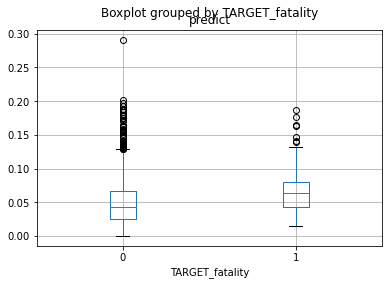

In [77]:
y_pred = pd.DataFrame(y_test)
y_pred.columns=['TARGET_fatality']
y_pred.loc[:, 'predict'] = m.predict(X_test)
y_pred.boxplot(column='predict', by = 'TARGET_fatality')
plt.show()

**Clustering**

In [154]:
df = data.copy()
df

,YEAR,TIME,HOUR,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,WARDNUM,DIVISION,...,REDLIGHT,ALCOHOL,DISABILITY,POLICE_DIVISION,HOOD_ID,NEIGHBOURHOOD,TARGET,Season,Month,TimeOfDay
_id,,,,,,,,,,,,,,,,,,,,,
1,2006,852,8,BLOOR ST W,DUNDAS ST W,None,Major Arterial,Toronto and East York,4,11,...,No,No,No,D11,88,High Park North (88),0,Spring,3,Morning
2,2006,852,8,BLOOR ST W,DUNDAS ST W,None,Major Arterial,Toronto and East York,4,11,...,No,No,No,D11,88,High Park North (88),1,Spring,3,Morning
3,2006,915,9,MORNINGSIDE AVE,SHEPPARD AVE E,None,Major Arterial,Scarborough,25,42,...,Yes,No,No,D42,131,Rouge (131),1,Spring,3,Morning
4,2006,915,9,MORNINGSIDE AVE,SHEPPARD AVE E,None,Major Arterial,Scarborough,25,42,...,Yes,No,No,D42,131,Rouge (131),0,Spring,3,Morning
5,2006,240,2,EGLINTON AVE E,COMMONWEALTH AVE,None,Major Arterial,Scarborough,"21,20",41,...,No,Yes,No,D41,138,Eglinton East (138),0,Spring,3,Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16856,2020,1340,13,BRIMLEY RD,BARKDENE HILLS,50 m South of,Other,Rest of GTA,Unknown,Unknown,...,No,No,No,D41,123,Cliffcrest (123),1,Summer,8,Afternoon
16857,2020,1205,12,EGLINTON AVE E,BELLAMY RD N,None,Major Arterial,Scarborough,"21,20",43,...,No,No,No,D43,138,Eglinton East (138),0,Fall,9,Afternoon
16858,2020,1205,12,EGLINTON AVE E,BELLAMY RD N,None,Major Arterial,Scarborough,"21,20",43,...,No,No,No,D43,138,Eglinton East (138),0,Fall,9,Afternoon


In [155]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit


categorical_vars = ['INVTYPE', 'INVAGE', 'ROAD_CLASS', 'DISTRICT', 'LOCCOORD', 
                    'ACCLOC', 'TRAFFCTL', 'VISIBILITY', 'LIGHT', 'RDSFCOND',
                    # flags for whether the accident involved these things
                    'PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH', 
                    'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY', 'TimeOfDay', 'Season']
discrete_vars = ['YEAR', 'HOUR','Month'] ## 'DATE',
continuous_vars = ['TIME']
dep_var = ['TARGET']

explanatory_var = categorical_vars + discrete_vars + continuous_vars
all_var = explanatory_var + dep_var
# data = data[all_var]

# Categorical - impute, one hot encode
cat_si_step = ('si', SimpleImputer(strategy='constant', fill_value='Other'))
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
cat_steps = [cat_si_step, cat_ohe_step]
cat_pipe = Pipeline(cat_steps)
cat_transformers = [('cat', cat_pipe, categorical_vars)]

# Numerical - impute, scale
num_si_step = ('si', SimpleImputer(strategy='median'))
num_scl_step = ('scl', MinMaxScaler())
num_steps = [num_si_step, num_scl_step]
num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, discrete_vars + continuous_vars)]

ct = ColumnTransformer(transformers=cat_transformers + num_transformers)
ct.fit(df[categorical_vars + discrete_vars + continuous_vars])
X = ct.transform(df[categorical_vars + discrete_vars + continuous_vars])
y = df[dep_var].values

In [156]:
# use k-means to split into natural groups
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(123)

import warnings
warnings.filterwarnings('ignore')

squared_dist = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    squared_dist.append(km.inertia_)

*The Elbow Method*

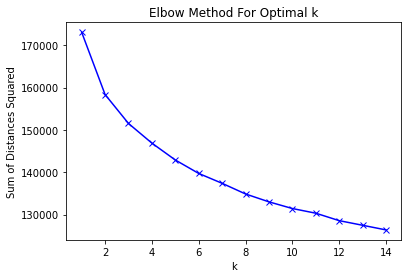

In [157]:
# elbow method to determine the optimal number of clusters
plt.plot(K, squared_dist, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Distances Squared')
plt.title('Elbow Method For Optimal k')
plt.show()

The Elbow method is a method of interpretation and validation of consistency within cluster analysis designed to help with finding the appropriate number of clusters in a dataset.

This method looks at the percentage of variance explained as a function of the number of clusters: One should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data. More precisely, if one plots the percentage of variance explained by the clusters against the number of clusters, the first clusters will add much information (explain a lot of variance), but at some point the marginal gain will drop, resulting in a kink in the graph. The number of clusters is chosen at this point. This is sometimes called the "elbow criterion".

Using the Elbow method it looks like 2 is the optimal number of clusters (this is where the kink occurs).

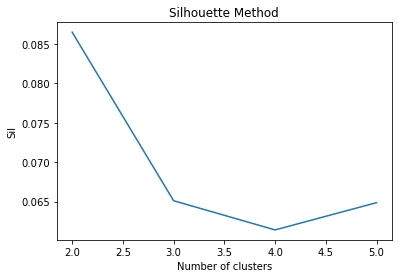

2:0.08650286907427435
3:0.06511636518763594
4:0.06141009148573714
5:0.0648679900759072


In [158]:
from sklearn.metrics import silhouette_score

sil = []

for k in range(2, 6):
  kmeans = KMeans(n_clusters = k).fit(X)  
  preds = kmeans.fit_predict(X)
  sil.append(silhouette_score(X, preds, metric = 'euclidean'))


plt.plot(range(2, 6), sil)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sil')
plt.show()

for i in range(len(sil)):
 print(str(i+2) +":"+ str(sil[i]))

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

The value of the Silhouette score varies from -1 to 1. If the score is 1, the cluster is dense and well-separated than other clusters. A value near 0 represents overlapping clusters with samples very close to the decision boundary of the neighboring clusters. A negative score [-1, 0] indicates that the samples might have got assigned to the wrong clusters.

It looks like K = 2 is the closest to 1, which is consistent with the elbow curve.

In [164]:
km2 = KMeans(n_clusters=2).fit(X)

# In order to visualize the clusters, ideally we'd go back to the original data in order to see the behavioural patterns,
# but since we need to look at the centroids as well, comparing to normalized data might make more sense.
df_withClusters = df
df_withClusters['cluster'] = km2.labels_
source = pd.read_csv('Motor Vehicle Collisions with KSI Data - 4326.csv', index_col=0)
df_withClusters['INJURY'] = source.INJURY
df_withClusters

,YEAR,TIME,HOUR,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,WARDNUM,DIVISION,...,DISABILITY,POLICE_DIVISION,HOOD_ID,NEIGHBOURHOOD,TARGET,Season,Month,TimeOfDay,cluster,INJURY
_id,,,,,,,,,,,,,,,,,,,,,
1,2006,852,8,BLOOR ST W,DUNDAS ST W,None,Major Arterial,Toronto and East York,4,11,...,No,D11,88,High Park North (88),0,Spring,3,Morning,1,None
2,2006,852,8,BLOOR ST W,DUNDAS ST W,None,Major Arterial,Toronto and East York,4,11,...,No,D11,88,High Park North (88),1,Spring,3,Morning,1,Fatal
3,2006,915,9,MORNINGSIDE AVE,SHEPPARD AVE E,None,Major Arterial,Scarborough,25,42,...,No,D42,131,Rouge (131),1,Spring,3,Morning,1,Fatal
4,2006,915,9,MORNINGSIDE AVE,SHEPPARD AVE E,None,Major Arterial,Scarborough,25,42,...,No,D42,131,Rouge (131),0,Spring,3,Morning,1,None
5,2006,240,2,EGLINTON AVE E,COMMONWEALTH AVE,None,Major Arterial,Scarborough,"21,20",41,...,No,D41,138,Eglinton East (138),0,Spring,3,Night,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16856,2020,1340,13,BRIMLEY RD,BARKDENE HILLS,50 m South of,Other,Rest of GTA,Unknown,Unknown,...,No,D41,123,Cliffcrest (123),1,Summer,8,Afternoon,0,Major
16857,2020,1205,12,EGLINTON AVE E,BELLAMY RD N,None,Major Arterial,Scarborough,"21,20",43,...,No,D43,138,Eglinton East (138),0,Fall,9,Afternoon,1,None
16858,2020,1205,12,EGLINTON AVE E,BELLAMY RD N,None,Major Arterial,Scarborough,"21,20",43,...,No,D43,138,Eglinton East (138),0,Fall,9,Afternoon,1,Minor


         TARGET  total    percent
cluster                          
0          2858   7268  39.323060
1          3631   9592  37.854462
INJURY   Fatal  Major  Minimal  Minor  None
cluster                                    
0          409   2449      385    564  2672
1          412   3219      657    747  3734


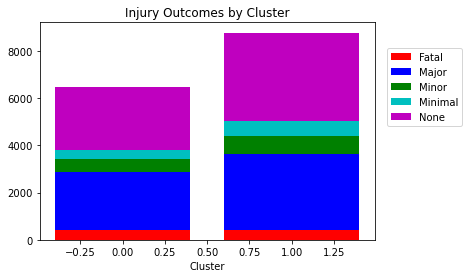

In [165]:
# does a natural pattern emerge among the clusters in terms of fatality variability?
summary_cluster = []
summary_cluster = df.groupby('cluster')['TARGET'].sum().to_frame()
summary_cluster['total'] = df.groupby('cluster')['TARGET'].count().to_frame()['TARGET']
summary_cluster['percent'] = summary_cluster['TARGET']/summary_cluster['total']*100
print(summary_cluster)

summary2 = df_withClusters.groupby(['cluster', 'INJURY'])['TARGET'].count().to_frame()
summary2 = summary2.reset_index()
summary2 = summary2.pivot(index='cluster', columns='INJURY', values='TARGET')
print(summary2)
import matplotlib.pyplot as plt
plt.bar(summary2.index, summary2.Fatal, color='r')
plt.bar(summary2.index, summary2.Major, bottom=summary2.Fatal, color='b')
plt.bar(summary2.index, summary2.Minor, bottom=summary2.Fatal+summary2.Major, color='g')
plt.bar(summary2.index, summary2.Minimal, bottom=summary2.Fatal+summary2.Major+summary2.Minor, color='c')
plt.bar(summary2.index, summary2['None'], bottom=summary2.Fatal+summary2.Major+summary2.Minor+summary2.Minimal, color='m')
plt.title("Injury Outcomes by Cluster")
plt.xlabel("Cluster")
plt.legend(['Fatal', 'Major', 'Minor', 'Minimal', 'None'], loc=8,bbox_to_anchor=(1.15, 0.5),ncol=1)
plt.show()

# it would appear it does not